# Prediction of Renewable Power Loss caused by Feed-in Management Events

In recent years the expansion of renewable generation capacity has been proceeding due to efforts being made to transition to low carbon energy systems. This development causes a variety of challenges including the intermittent availability of renewable generation, such as wind energy, as well as the need for construction of according transmission infrastructure. The resulting mismatch between transmission and generation infrastructure causes congestion in the transmission grid. Germanys electricity market relies on feed-in managment to cure short-time congestion when grids cannot absorb all intermittent generation. 

The term feed-in management refers to the curtailment of power that is fed into the power grid (`available power`) in dependence of the power that is actually used by connected consumers or is being transferred on to other grid areas (`consumed power`). Both of these values need to be in a perfect balance for every 15 minute interval to ensure grid stability. Against this background, especially renewable energy systems like wind turbines pose a big challenge, since by default by default the power from these systems is very volatile. 

![balance](./figures/balance.png)

Feed-in management is organized and ordered by the Transmission System Operators (TSOs) (TenneT TSO GmbH for the discussed wind farm). With the aid of feed-in management, grid operating  resources such as overhead lines or transformers are protected from overloads. Without feed-in management, sections of the grid could become overloaded during strong wind, leading to supply failures. Feed-in management enables the optimal use of the grids for the  incorporation of wind energy without also endangering the security of supply. 



<img src="./figures/grid_zones_germany.jpg" alt="grid_areas_germany" width="300" />



In the context of the so-called smart grid, the intelligent management of electricity demand, also referred to as demand side management (DSM), has been recognized as an effective approach to increase the use of renewable energy, using energy that would otherwise potentially be curtailed in an feed-in managment event. Demand Side Management applications schedule high energy consuming processes to times when energy is cheap and excess energy is available. Examples of Demand Side Managment applications include [Distributed Heating](https://www.sciencedirect.com/science/article/pii/S1876610217306781), [industrial refrigerators](https://elib.uni-stuttgart.de/bitstream/11682/9198/3/Dissertation_Martin_Steurer.pdf), [air conditionors](www.businessgreen.com/bg/analysis/1804282/volatile-energy-prices-demand-form-management), [Cloud Storage](https://www.windcloud.de/), [Power-to-Gas-plants](https://www.dena.de/fileadmin/dena/Publikationen/PDFs/2019/Roadmap_Power_to_Gas.pdf). In order to schedule Demand Side Managment applications, a prediction of feed-in managment events is needed. 

Aditionally, Anticipating these energy management situations in advance is crucial in order to prevent direct marketers of renewable energy from having to fill supply gaps by buying on the intraday exchange to often (highly) increased prices compared to preceding day ahead prices.

<img src="./figures/dsm_vis.png" alt="dsm_vis" width="800" />

In this project, we provide, evaluate and compare models that predict feed-in managment on the wind farm level. 


### Project Organisation

The project is organized as seen below: 

- [FeedInMngmt_presentation.pdf](FeedInMngmt_presentation.pdf): Presentation of the project including additional explanation about the feed-in managment sitatuion. (to be uploaded)
- [FeedInMngmt_EDA.ipynb](FeedInMngmt_EDA.ipynb): Loading and pre-processing feed-in managment data as well as weather data, price data and energy consumption data. Followed by an exploration of the given data as well as an investigation of correlating behavior of various time series (e.g., the influence of wind on feed in management events). This document ends with a ranking and selection of features by their importance.  
- [FeedInMngmt_Base_Models.ipynb](FeedInMngmt_Base_Models.ipynb): Creation and elaboration of train-validation-test split as well as design of two naive baseline models: the Shift model (e.g., the next timestep equals the last time step) and an  Exponential Smoothing model (e.g., next timestep equals the moving average over the last X hours). In addition, functions to evaluate the test results are described in this document.  
- [FeedInMngmt_Prophet.ipynb](FeedInMngmt_Prophet.ipynb): Implementation and evaluation of a FB Prophet Model for the prediction of one timestep and multiple timesteps into the future. 
- [FeedInMngmt_LSTM_NN.ipynb](FeedInMngmt_LSTM_NN.ipynb): Implementation and evaluation of a Long-Short-Term-Memory Recurrent Neural Network for the prediction of one timestep and multiple timesteps into the future. 
- [FeedInMngmt_Results.ipynb](FeedInMngmt_Results.ipynb): Evaluation of the different models based on the chosen test metrics. (to be uploaded)

## Wind Farm Location

The windfarm of interest is located south-east of Bremen (Germany), at the following [gelocation](https://goo.gl/maps/tpQwu73smEUZ3sri8).

- `lot = 52°46'10.9"N`
- `long = 8°38'38.1"E`

Sadly we did not have the time to visit the windpark ourselfs, but  with the help of Google Maps, we got a quick look at the windfarm.

<img src="./figures/location.png" alt="location" width="1000" />

## Feature Explanation
<br>
<br>

### Energy System Data

| Variable                   | Description                                                                                     | Unit      |
|----------------------------|-------------------------------------------------------------------------------------------------|-----------|
| power_mw_obsnorm           | Power fed into the system, normed                                                               | [-]     |
| power_available_mw_obsnorm | Potentially available power supply, normed                                                      | [-]     |
| target_losses_norm         | Power Loss due to Feed-In Managment Events, <br> power supply shut down during management situations | [-]     |
| NetConsumption_MW          | Consumption Data for the Tennet Grid                                                            | [MW]      |
| energyprice_euro_MWh       | Hourly German Spot Market Energy Prices                                                          | [€ / MWh] |

### GFS Data



|    **Variable**   	|                                    **Description**                                   	| **Unit** 	|
|:-----------------:	|:------------------------------------------------------------------------------------:	|:--------:	|
|   dswrf_sfc_wm2   	| Net Downward Shortwave Radiation Flux                                                	|  [W/m^2] 	|
|    gust_sfc_ms    	| Wind Gust Surface                                                                    	|   [m/s]  	|
|     hpbl_sfc_m    	| Planetary Boundary Layer Height                                                      	|    [m]   	|
|     msl_ms_pa     	| Mean Sea Level Pressure                                                              	|   [Pa]   	|
| pottemp_80mto0m_K 	| Potential Temperature Difference between 80m and 0m                                  	|    [K]   	|
|       q_2m_1      	| Specific Humidity in 2m height                                                       	|    [-]   	|
|     q_pfg30_1     	| Specific Humidity Mean over first 30 hPa (~250m)                                     	|    [-]   	|
|      rpl925%      	| Relative Humidity in 925 hPa pressure level                                          	|    [%]   	|
|      rpl950%      	| Relative Humidity in 950 hPa pressure level                                          	|    [%]   	|
|   shtfl_sfc_wm2   	| Net Sensible Heat Flux (conductive heat flux of the Earth surface to the atmosphere) 	|  [W/m^2] 	|
|      t_100m_k     	| Temperature in 100m height                                                           	|    [K]   	|
|       t_2m_k      	| Temperature in 2m height                                                             	|    [K]   	|
|     t_pfg30_k     	| Temperature Mean over first 30 hPa (~250m)                                           	|    [K]   	|
|     tcclowsfc%    	| Total Cloud Cover, low level clouds (0km - 2km height)                               	|    [%]   	|
|   tccmediumsfc%   	| Total Cloud Cover, mid level clouds (2km - 7km height)                               	|    [%]   	|
|    wdir_100m_dn   	| Wind Direction in 100m height                                                        	|    [°]   	|
|    wdir_10m_dn    	| Wind Direction in 10m height                                                         	|    [°]   	|
|   wdir_pfg30_dn   	| Wind Direction Mean over first 30 hPa (~250m)                                        	|    [°]   	|
|   wdir_pl925_dn   	| Wind Direction in 925 hPa pressure level                                             	|    [°]   	|
|    wsp_100m_ms    	| Wind Speed in 100m height                                                            	|   [m/s]  	|
|     wsp_10m_ms    	| Wind Speed in 10m height                                                             	|   [m/s]  	|
|    wsp_pfg30_ms   	| Wind Speed Mean over first 30 hPa (~250m)                                            	|   [m/s]  	|
|    wsp_pl925_ms   	| Wind Speed in 925 hPa pressure level                                                 	|   [m/s]  	|
|     created_on    	| date and 24 hours divided in 6 hour intervals                                        	|  [date]  	|
|      azimuth      	| Azimuth angle of the sun                                                             	|    [°]   	|
|     elevation     	| Elevation angle of the sun                                                           	|    [°]   	|

# Environment Set-Up

## Load relevant Python Packages

In [1]:
reset -fs

In [2]:
# Importing the most important modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from matplotlib import pyplot
import matplotlib.dates as mdates

# For data reading and data export
import os, glob
from pathlib import Path
from pandas import read_csv

# For data cleaning
from datetime import datetime
import missingno as msno

# For data exploration
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Global Variables and Settings

In [3]:
# Setting the random seed for reproducability and several plotting style parameters
%matplotlib inline
plt.style.use('seaborn')
sns.set(rc={'figure.figsize':(14,8)})
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
RSEED = 42

color_1 = 'goldenrod'
color_2 = 'darkred'

# Loading Datasets & First Cleaning

## GFS Data --> `df_features`

In [4]:
# reading in the feature dataframe
with open('./data/griddata_gfs_us_20180101_20190826_03_final.p', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    df_features = u.load()

# rename columns, which contain symbols
df_features = df_features.rename(columns={'r_pl925_%': 'r_pl925_perc','r_pl950_%': 'r_pl950_perc',
                        'tcclow_sfc_%': 'tcclow_sfc_perc','tccmedium_sfc_%': 'tccmedium_sfc_perc'})

In [5]:
print('First and last observations:')
pd.concat([df_features.head(2), df_features.tail(2)])

First and last observations:


,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,r_pl925_perc,r_pl950_perc,shtfl_sfc_wm2,t_100m_k,t_2m_k,t_pfg30_k,tcclow_sfc_perc,tccmedium_sfc_perc,wdir_100m_dn,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,created_on,azimuth,elevation
index,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01 06:00:00+00:00,0.0,16.777032,1349.927656,99212.06250,0.559356,0.005105,0.004852,89.975,83.075,-58.444885,280.079346,280.496348,279.811816,99.375,49.50,54.455224,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,2018-01-01 00:00:00+00:00,111.880959,-12.132894
2018-01-01 07:00:00+00:00,0.0,16.606744,1352.623506,99259.81250,0.528755,0.005005,0.004739,89.250,82.250,-59.127808,279.950000,280.339922,279.664160,99.250,79.25,62.428351,59.839207,62.809819,66.607932,16.795002,9.966123,16.832585,21.917341,2018-01-01 00:00:00+00:00,122.901711,-3.799353
2019-08-26 17:00:00+00:00,217.0,6.996934,294.434175,101819.59375,0.721496,0.013280,0.011999,66.625,64.775,-17.322095,297.000000,297.050024,297.000000,0.000,0.00,253.352783,249.491241,254.108723,307.177015,6.489624,3.745793,6.426924,5.507465,2019-08-23 18:00:00+00:00,272.617737,12.060012
2019-08-26 18:00:00+00:00,79.5,8.050885,215.534009,101816.78750,1.798953,0.012720,0.011877,66.800,64.175,-38.183350,296.250000,294.969312,296.000000,0.000,0.00,250.512384,244.554716,251.835064,308.818931,7.496367,3.839874,7.413974,5.639764,2019-08-23 18:00:00+00:00,284.064789,2.764322


## Quadra Data --> `df_target`

In [6]:
# reading in the target dataframe
with open('./data/obs_20180101_20190625_03_final_normed.p', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    df_target = u.load()

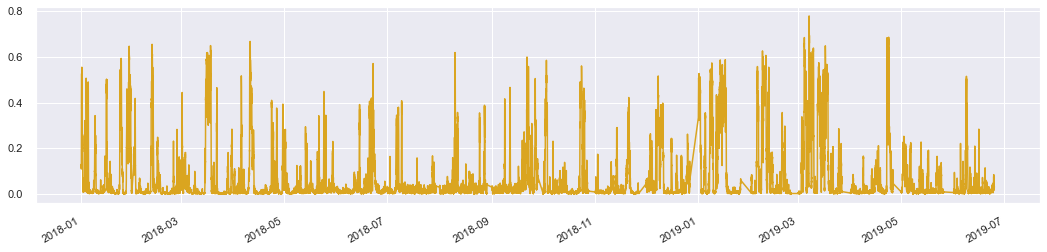

In [7]:
df_target.target_losses_norm.plot(color=color_1, figsize=(18, 4));

In [8]:
print('First and last observations:')
pd.concat([df_target.head(2), df_target.tail(2)])

First and last observations:


,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm
2018-01-01 00:00:00+01:00,0.330269,0.450934,0.120665
2018-01-01 00:10:00+01:00,0.339204,0.457539,0.118335
2019-06-25 01:40:00+02:00,0.308457,0.338645,0.030189
2019-06-25 01:50:00+02:00,0.309148,0.339853,0.030705


## Consumption Data Tennet Grid --> `df_cons`

In [9]:
## Loading Data
df_cons = pd.read_csv("./data/Consumption.csv", delimiter = ";", decimal = ',',parse_dates = [["Datum", "Startzeit"]] )
# pre-processing of data, e.g., timestamp index and colm title
df_cons.index = pd.to_datetime(df_cons.Datum_Startzeit, format = "%Y-%m-%d %H:%M:%S")
df_cons.drop(columns = ["Datum_Startzeit", "Endzeit"], inplace = True)
df_cons.columns = ["NetConsumption_MW"]
df_cons["NetConsumption_MW"] = pd.to_numeric(df_cons["NetConsumption_MW"])

# dealing with duplicate indices
df_cons = df_cons[~df_cons.index.duplicated(keep='first')]

# forward filling the outliers (zero consumption)
df_cons['NetConsumption_MW'] = df_cons['NetConsumption_MW'].replace(to_replace=0, method='ffill')

In [10]:
print('First and last observations:')
pd.concat([df_cons.head(2), df_cons.tail(2)])

First and last observations:


,NetConsumption_MW
Datum_Startzeit,
2018-01-01 00:00:00,3743.9
2018-01-01 00:15:00,3742.0
2020-06-30 23:30:00,5880.2
2020-06-30 23:45:00,5670.9


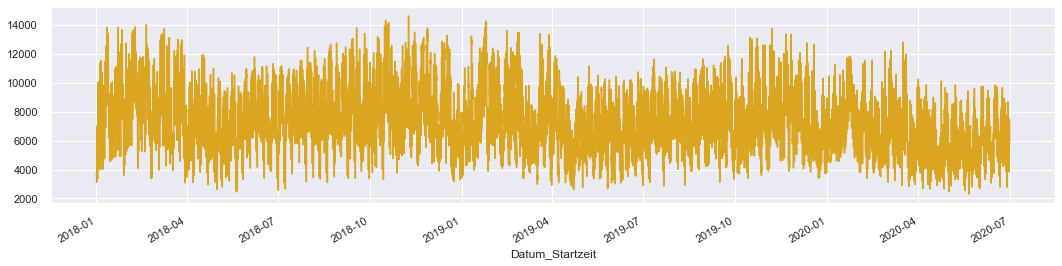

In [11]:
df_cons.NetConsumption_MW.plot(color=color_1, figsize=(18, 4));

## German Energy Price Data --> `df_price`

In [12]:
#loading data from CSV
df_price = pd.read_csv("./data/Energyprice.csv", delimiter = ";", decimal = ',', parse_dates = [["Datum", "Uhrzeit"]] )

# timestamp index for dataframe
indices = [pd.to_datetime("2018-01-01 00:00:00")]
for i in range (len(df_price)-1):
    indices.append(pd.to_datetime(indices[0]) + (i+1)*pd.Timedelta(hours=1))
indices.sort()
df_price.index = indices
df_price.drop(columns = ["Datum_Uhrzeit"], inplace = True) #drop old timestamp data

# renaming of column 
df_price.columns = ["energyprice_euro_MWh"]

# ensuring numeric values 
df_price["energyprice_euro_MWh"] = pd.to_numeric(df_price["energyprice_euro_MWh"])

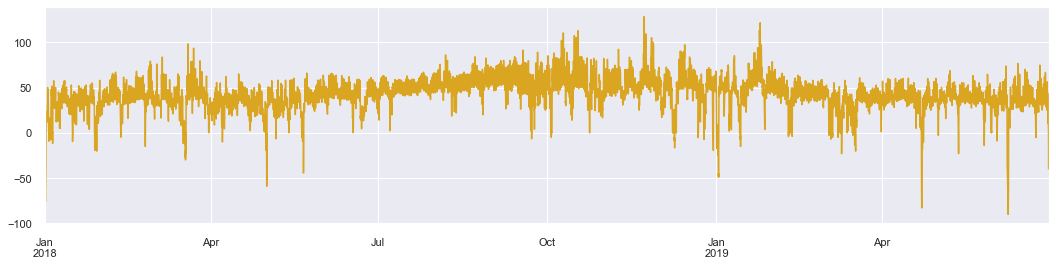

In [13]:
df_price["energyprice_euro_MWh"].plot(color=color_1, figsize=(18, 4));

In [14]:
print('First and last observations:')
pd.concat([df_cons.head(2), df_cons.tail(2)])

First and last observations:


,NetConsumption_MW
Datum_Startzeit,
2018-01-01 00:00:00,3743.9
2018-01-01 00:15:00,3742.0
2020-06-30 23:30:00,5880.2
2020-06-30 23:45:00,5670.9


## Initial Observations

**Observations:**
- **datasets:** At this point there are 4 datasets: 
    - `df_features`--> GFS Data
    - `df_target`--> Feed In Mngmt Data Normalized
    - `df_price`--> Price Data for Germany in Euro / MW
    - `df_consumption`--> Consumption Data for TenneT Grid in MW
- **Timezones:** The timezones in the datasets are inconsistent
- **Frequency**
    - `df_features`: hourly frequency
    - `df_target`: 15 minute frequency
    - `df_price`: 15 minute frequency
    - consumption data: 15 minute frequency
- **Timeframe**
    - `df_features`: 1st Jan 2018 06:00 to 26th Aug 2019 18:00
    - `df_target`: 1st Jan 2018 00:00  to 25th Jun 2019 01:50
    - `df_price`: 1st Jan 2018 00:00  to 25th 30th Jun 2010 22:00
    - `df_consumption` data: 1st Jan 2018 00:00  to 30th Jun 2020 23:45



**Resulting Steps**: 
- DataFrames: Merging Data into one DataFrame
- timezones: creating consistency for timezones
- frequency: resample feature data to have 10 minute frequency
- timeframes: reducing timeframes to have congruent timeframes

# Data Cleaning

## Timezone

In [15]:
# converting to same timezone
df_features.index = df_features.index.tz_localize(None).to_series(keep_tz=True)

In [16]:
# converting target data to the same timezone as the feature dataframe
df_target.index = df_target.index.tz_localize(None).to_series(keep_tz=True)

## Frequency

In [17]:
# resampling to a frequency of 10 minutes by interpolating between the hourly values
df_features = df_features.resample('10min', axis='index').interpolate()

# resampling to a frequency of 10 minutes by interpolating between the hourly values
df_price = df_price.resample('10min', axis='index').interpolate()

# resampling to a frequency of 10 minutes by interpolating between the hourly values
df_cons = df_cons.resample('10min', axis='index').interpolate()

Considering that the Energy Consumption and the Energy Price of the next time step would be two more values that need predictions, the time series for these variables are shifted by one time interval to make them the lagged energy consumption and price, which are known at the corresponging time.

In [18]:
#shifting data, so that the feature is the consumption of the past timestep
df_cons['NetConsumption_MW'] = df_cons['NetConsumption_MW'].shift(1)

#shifting data, so that the feature is the energy price of the past timestep
df_price["energyprice_euro_MWh"] = df_price["energyprice_euro_MWh"].shift(1)

#renaming the additional data columns
df_cons.columns = ["lagged_NetConsumption_MW"]
df_price.columns = ["lagged_energyprice_euro_MWh"]

## Combining DataFrames

In [19]:
# combining both dataframes to have one to work in
df = pd.concat([df_target,df_cons,df_price,df_features], axis=1)

In [20]:
print('First and last observations:')
pd.concat([df.head(2), df.tail(2)])

First and last observations:


,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,lagged_NetConsumption_MW,lagged_energyprice_euro_MWh,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,r_pl925_perc,r_pl950_perc,shtfl_sfc_wm2,t_100m_k,t_2m_k,t_pfg30_k,tcclow_sfc_perc,tccmedium_sfc_perc,wdir_100m_dn,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,created_on,azimuth,elevation
2018-01-01 00:00:00,0.330269,0.450934,0.120665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:10:00,0.339204,0.457539,0.118335,3743.9,-5.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-30 23:30:00,NaN,NaN,NaN,6042.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-30 23:40:00,NaN,NaN,NaN,5880.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Continuity Check

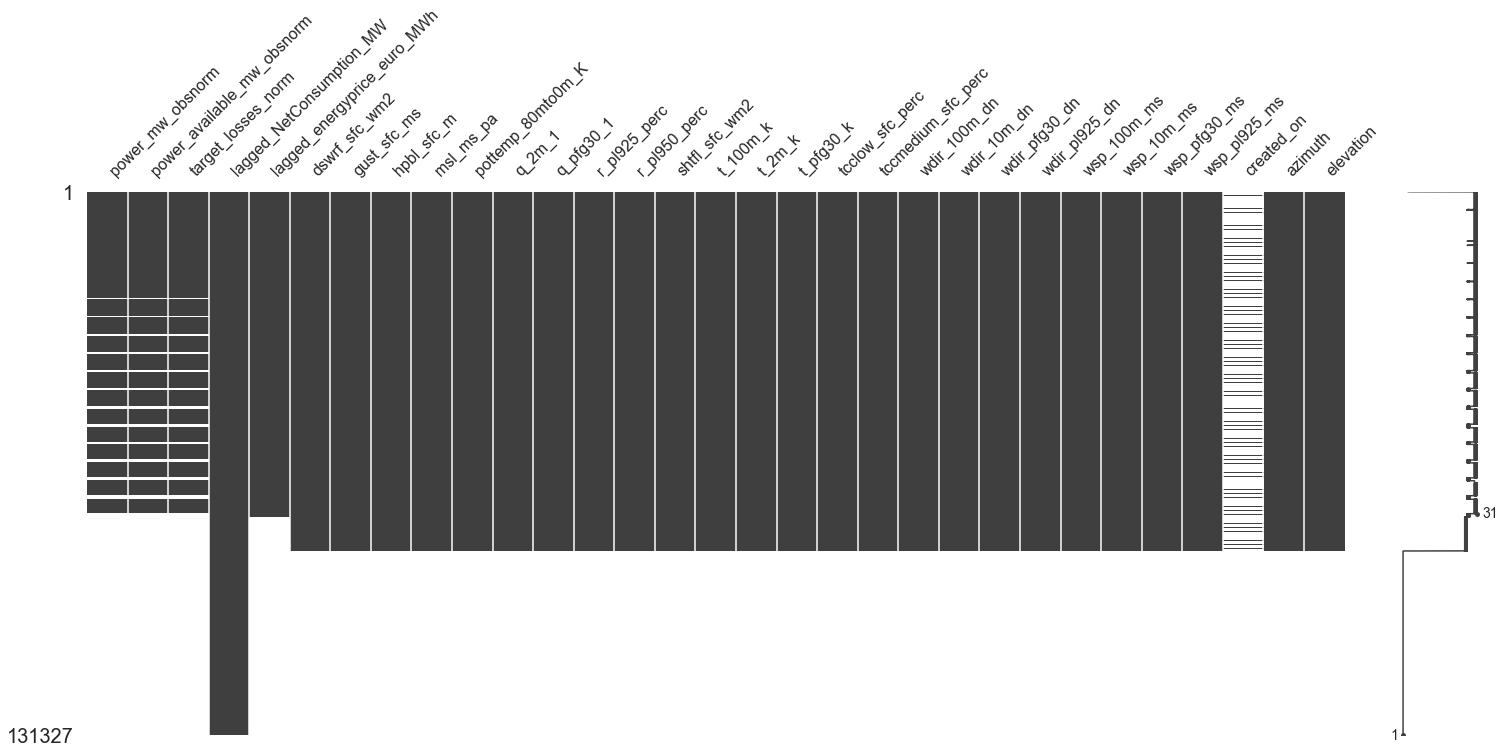

In [21]:
msno.matrix(df);

**Observations:**
- `created_on`: frequency interpolation did not work for TimeStamp data (created_on), column will be dropped anyway. 
- target dataframe (first three coloumns): harmonisation of overall timeframe needed
- target data is discontinuous

In [22]:
# Percentage and Number of NaN-Values
missing = pd.DataFrame(df.isnull().sum(),columns=['Number'])
missing['Percentage'] = round(missing.Number/df.shape[0]*100,1)
print()
print('MISSING VALUES (absolut and in percent)')
missing[missing.Number!=0].T


MISSING VALUES (absolut and in percent)


,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,lagged_NetConsumption_MW,lagged_energyprice_euro_MWh,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,r_pl925_perc,r_pl950_perc,shtfl_sfc_wm2,t_100m_k,t_2m_k,t_pfg30_k,tcclow_sfc_perc,tccmedium_sfc_perc,wdir_100m_dn,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,created_on,azimuth,elevation
Number,60617.0,60617.0,60617.0,1.0,52715.0,44566.0,44566.0,44566.0,44566.0,44566.0,44566.0,44566.0,44566.0,44566.0,44566.0,44566.0,44566.0,44566.0,44566.0,44566.0,44566.0,44566.0,44566.0,44566.0,44566.0,44566.0,44566.0,44566.0,116949.0,44566.0,44566.0
Percentage,46.2,46.2,46.2,0.0,40.1,33.9,33.9,33.9,33.9,33.9,33.9,33.9,33.9,33.9,33.9,33.9,33.9,33.9,33.9,33.9,33.9,33.9,33.9,33.9,33.9,33.9,33.9,33.9,89.1,33.9,33.9


## Dropping Column "created_on"

In [23]:
df.drop(columns = ["created_on"], inplace = True)

## Timeframe harmonisation

In [24]:
start_index_str = "2018-01-01 06:00:00"
start_index = pd.to_datetime(start_index_str)

end_index_str = "2019-06-25 01:50:00"
end_index = pd.to_datetime(end_index_str)

print('Start Index of united DataFrame: ', start_index)
print('End Index of united DataFrame: ', end_index)

Start Index of united DataFrame:  2018-01-01 06:00:00
End Index of united DataFrame:  2019-06-25 01:50:00


In [25]:
df = df[(df.index <= end_index) & (df.index >= start_index)]
print('First and last observations:')
pd.concat([df.head(2), df.tail(2)])

First and last observations:


,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,lagged_NetConsumption_MW,lagged_energyprice_euro_MWh,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,r_pl925_perc,r_pl950_perc,shtfl_sfc_wm2,t_100m_k,t_2m_k,t_pfg30_k,tcclow_sfc_perc,tccmedium_sfc_perc,wdir_100m_dn,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,azimuth,elevation
2018-01-01 06:00:00,0.486251,0.911849,0.425598,3142.133333,-71.616667,0.0,16.777032,1349.927656,99212.062500,0.559356,0.005105,0.004852,89.975000,83.075000,-58.444885,280.079346,280.496348,279.811816,99.375000,49.500000,54.455224,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,111.880959,-12.132894
2018-01-01 06:10:00,0.528225,0.932739,0.404513,3144.800000,-72.540000,0.0,16.748651,1350.376965,99220.020833,0.554256,0.005088,0.004833,89.854167,82.937500,-58.558706,280.057788,280.470277,279.787207,99.354167,54.458333,55.784078,53.253883,56.181451,60.237190,16.589409,9.804977,16.657162,21.955989,113.717751,-10.743970
2019-06-25 01:40:00,0.308457,0.338645,0.030189,5703.500000,24.065000,0.0,9.875370,224.096558,102141.404167,2.363946,0.009756,0.009464,49.275000,46.033333,-50.096021,291.646208,289.825765,291.759709,0.000000,0.000000,306.634403,295.683603,309.412828,343.164726,8.642075,4.004936,8.761264,9.492873,31.591799,-9.437372
2019-06-25 01:50:00,0.309148,0.339853,0.030705,5657.000000,23.926667,0.0,9.713995,217.509660,102131.514583,2.370229,0.009704,0.009422,48.712500,45.616667,-49.312354,291.570260,289.732206,291.704854,0.000000,0.000000,306.528820,295.343899,309.409961,343.030446,8.607915,3.982537,8.720545,9.338253,33.775887,-8.668407


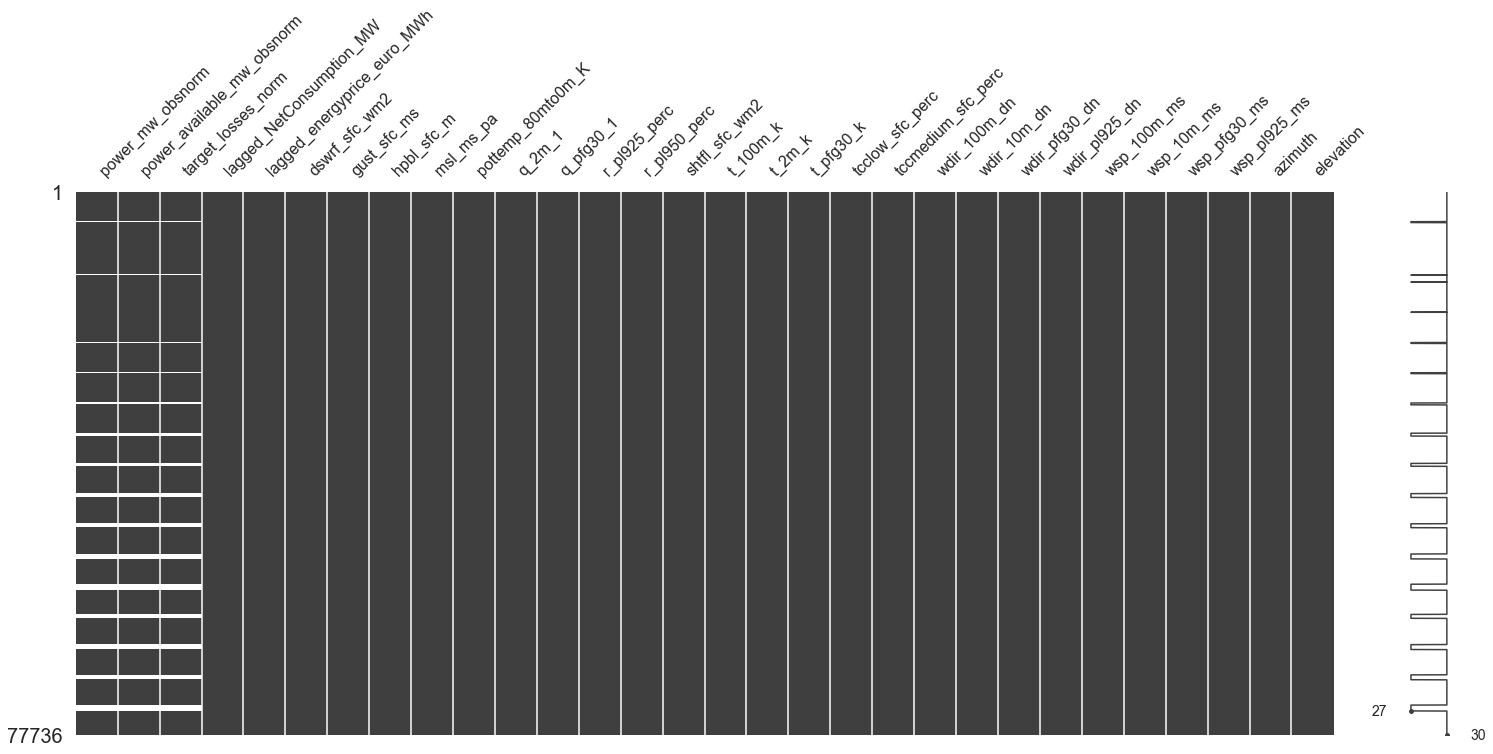

In [26]:
msno.matrix(df);

## Checking for duplicate timestamps

In [27]:
np.any(df.index.duplicated())

False

There are no duplicate timestamps in the dataframe.

## Discontinuous target data

**Problem:** As described above, while working on the dataset it became obvious that the target data (target_losses) is not continuous, e.g., several timeframes were missing. 

**Solution:** as an interpolation strategy the *Standard Week* is computed, a representation of the median hour on every day of the week, e.g., a 'Standard Monday', a 'Standard Tuesday'. This Standard Week is then used to fill the data gap. This is done for all three target data features (e.g., power_mw_obsnorm, power_available_mw_obsnorm,  target_losses_norm).

### Inspection of discontinuous  target data

At first glance, the data seems continuous: 

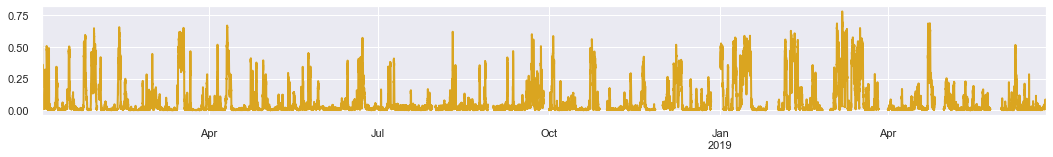

In [28]:
df.target_losses_norm.plot(figsize=(18, 2), color=color_1, linewidth=2);

But inspecting very close, there are gaps within the target data:

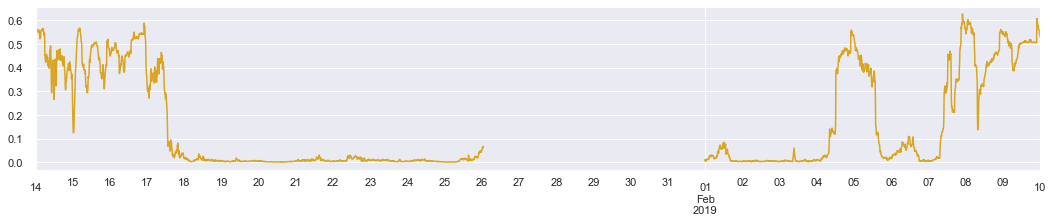

In [29]:
start_index = pd.to_datetime("2019-01-14 00:00:00")
end_index = pd.to_datetime("2019-02-10 00:00:00")
df.target_losses_norm[start_index:end_index].plot(figsize=(18, 3), color=color_1);

### Dealing with discontinuous target data

In [30]:
df['index1'] = df.index
# creating columns for the different time intervals the observations can be grouped by
df['Date'] = pd.to_datetime(df.index1.dt.date)
df['year'] = df.index1.dt.year
df['month'] = df.index1.dt.month
df['day'] = df.index1.dt.day
df['hour'] = df.index1.dt.hour
df['minute'] = df.index1.dt.minute

# creating a weekday column
weekdays = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3: 'Thursday', 4: 'Friday', 5:'Saturday', 6:'Sunday'}
df['weekday'] = df.index1.dt.weekday.map(weekdays)

# creating a float representation of every possible time interval in one Standard Week
df['day_hour_minute'] = df.index1.dt.weekday + df['hour']*1/24 + (df['minute']//10 * 1/144)

df.drop(columns = ["index1"], inplace = True)
df.head(2)

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,lagged_NetConsumption_MW,lagged_energyprice_euro_MWh,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,r_pl925_perc,r_pl950_perc,shtfl_sfc_wm2,t_100m_k,t_2m_k,t_pfg30_k,tcclow_sfc_perc,tccmedium_sfc_perc,wdir_100m_dn,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,azimuth,elevation,Date,year,month,day,hour,minute,weekday,day_hour_minute
2018-01-01 06:00:00,0.486251,0.911849,0.425598,3142.133333,-71.616667,0.0,16.777032,1349.927656,99212.062500,0.559356,0.005105,0.004852,89.975000,83.0750,-58.444885,280.079346,280.496348,279.811816,99.375000,49.500000,54.455224,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,111.880959,-12.132894,2018-01-01,2018,1,1,6,0,Monday,0.250000
2018-01-01 06:10:00,0.528225,0.932739,0.404513,3144.800000,-72.540000,0.0,16.748651,1350.376965,99220.020833,0.554256,0.005088,0.004833,89.854167,82.9375,-58.558706,280.057788,280.470277,279.787207,99.354167,54.458333,55.784078,53.253883,56.181451,60.237190,16.589409,9.804977,16.657162,21.955989,113.717751,-10.743970,2018-01-01,2018,1,1,6,10,Monday,0.256944


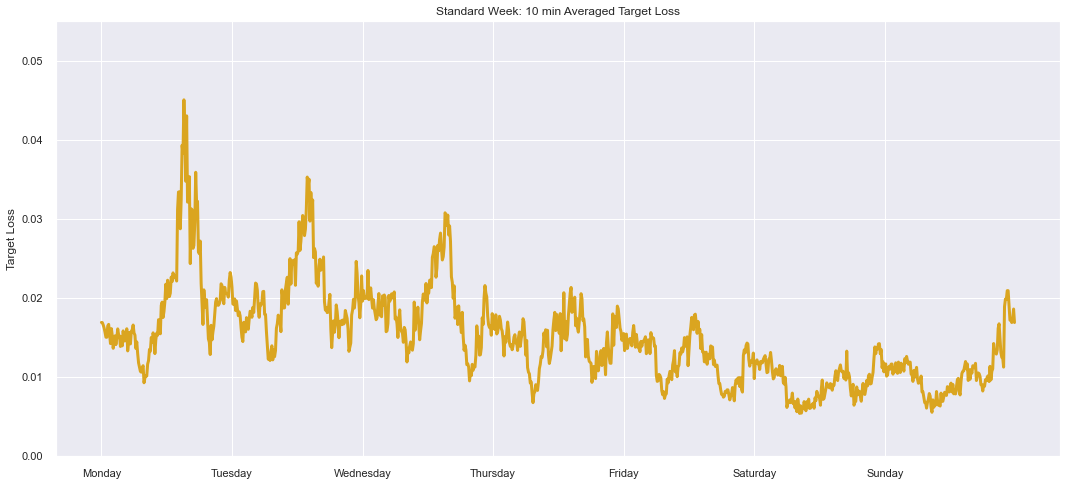

In [31]:
#Plotting median losses observed for every 10-min interval over a week
df.groupby('day_hour_minute')['target_losses_norm'].median().plot(figsize=(18, 8), color=color_1, linewidth=3)
_ = plt.ylabel('Target Loss')
_ = plt.xlabel('')
_ = plt.ylim([0, max(df.groupby('day_hour_minute')['target_losses_norm'].median()) + 0.01])
#the xticks are values between 0 and 7 (e.g., just like day_hour_minute), hence the np.arange() command
_ = plt.xticks(np.arange(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
_ = plt.title('Standard Week: 10 min Averaged Target Loss')

In [32]:
# creating series objects with the different timestamps of a day and their corresponding median values for target data
day_hour_minute_medians_loss = df.groupby('day_hour_minute')['target_losses_norm'].median().reset_index()
day_hour_minute_medians_available = df.groupby('day_hour_minute')['power_available_mw_obsnorm'].median().reset_index()
day_hour_minute_medians_cons = df.groupby('day_hour_minute')['power_mw_obsnorm'].median().reset_index()

# creating dictionaries to map the median values to the according timestamps
day_hour_minute_medians_loss_dict = dict(zip(day_hour_minute_medians_loss.day_hour_minute, day_hour_minute_medians_loss.target_losses_norm))
day_hour_minute_medians_available_dict = dict(zip(day_hour_minute_medians_available.day_hour_minute, day_hour_minute_medians_available.power_available_mw_obsnorm))
day_hour_minute_medians_cons_dict = dict(zip(day_hour_minute_medians_cons.day_hour_minute, day_hour_minute_medians_cons.power_mw_obsnorm))

# mapping the median values to the according timestamps
df["median_losses"] = df["day_hour_minute"].map(day_hour_minute_medians_loss_dict)
df["median_available"] = df["day_hour_minute"].map(day_hour_minute_medians_available_dict)
df["median_cons"] = df["day_hour_minute"].map(day_hour_minute_medians_cons_dict)

# filling in the nan values in our target data with the median value for the corresponding timestamp on the day
df["target_losses_norm"].fillna(df["median_losses"], inplace=True)
df["power_available_mw_obsnorm"].fillna(df["median_losses"], inplace=True)
df["power_mw_obsnorm"].fillna(df["median_losses"], inplace=True)

# dropping the columns with the median values again
df.drop(columns = ["median_losses", "median_available", "median_cons"], inplace = True)

df.head(2)

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,lagged_NetConsumption_MW,lagged_energyprice_euro_MWh,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,r_pl925_perc,r_pl950_perc,shtfl_sfc_wm2,t_100m_k,t_2m_k,t_pfg30_k,tcclow_sfc_perc,tccmedium_sfc_perc,wdir_100m_dn,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,azimuth,elevation,Date,year,month,day,hour,minute,weekday,day_hour_minute
2018-01-01 06:00:00,0.486251,0.911849,0.425598,3142.133333,-71.616667,0.0,16.777032,1349.927656,99212.062500,0.559356,0.005105,0.004852,89.975000,83.0750,-58.444885,280.079346,280.496348,279.811816,99.375000,49.500000,54.455224,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,111.880959,-12.132894,2018-01-01,2018,1,1,6,0,Monday,0.250000
2018-01-01 06:10:00,0.528225,0.932739,0.404513,3144.800000,-72.540000,0.0,16.748651,1350.376965,99220.020833,0.554256,0.005088,0.004833,89.854167,82.9375,-58.558706,280.057788,280.470277,279.787207,99.354167,54.458333,55.784078,53.253883,56.181451,60.237190,16.589409,9.804977,16.657162,21.955989,113.717751,-10.743970,2018-01-01,2018,1,1,6,10,Monday,0.256944


In [33]:
# Percentage and Number of NaN-Values
missing = pd.DataFrame(df.isnull().sum(),columns=['Number'])
missing['Percentage'] = round(missing.Number/df.shape[0]*100,1)
print()
print('MISSING VALUES (absolut and in percent)')
missing[missing.Number!=0].T


MISSING VALUES (absolut and in percent)


""
Number
Percentage


### Solution: continuous target data

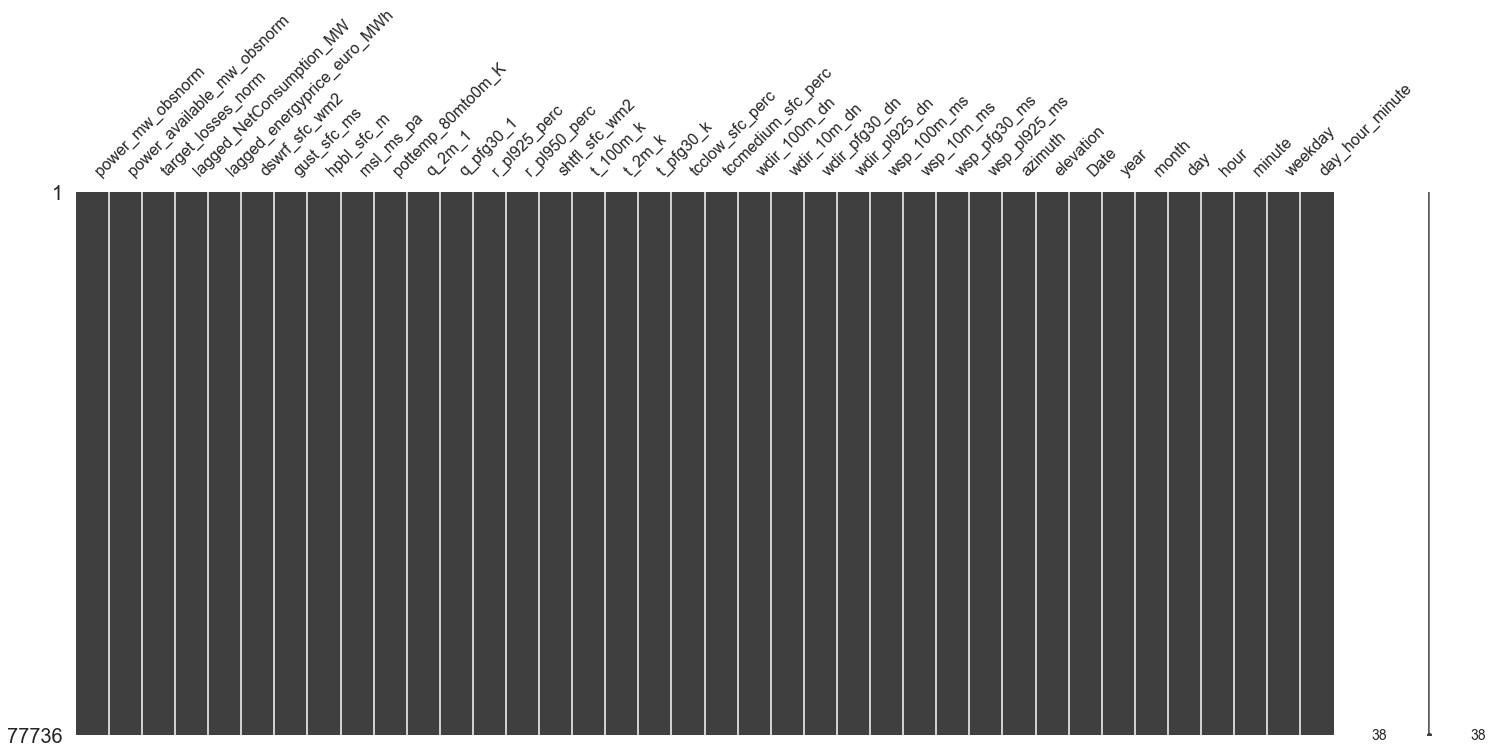

In [34]:
msno.matrix(df);

**Observation:** In the following graph the data gaps are filled. 

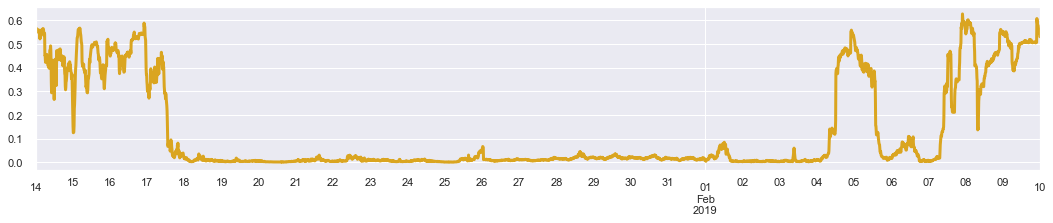

In [35]:
start_index = pd.to_datetime("2019-01-14 00:00:00")
end_index = pd.to_datetime("2019-02-10 00:00:00")
df.target_losses_norm[start_index:end_index].plot(figsize=(18, 3), color=color_1, linewidth=3);

# Inconsistent / Artificial Timespan in GFS data

Within the GFS data seemingly inconsistent / artificial data is observed, beginning at `2019-04-30 15:00:00` and lasting until `2019-05-04 07:00:00`, visualized below. 

In [36]:
#calculating timedelta  
start_index = pd.to_datetime("2019-04-30 15:00:00")
end_index = pd.to_datetime("2019-05-04 07:00:00")
print('Timedelta: ', start_index - end_index)

Timedelta:  -4 days +08:00:00


## Inspection of inconsistent / artificial data

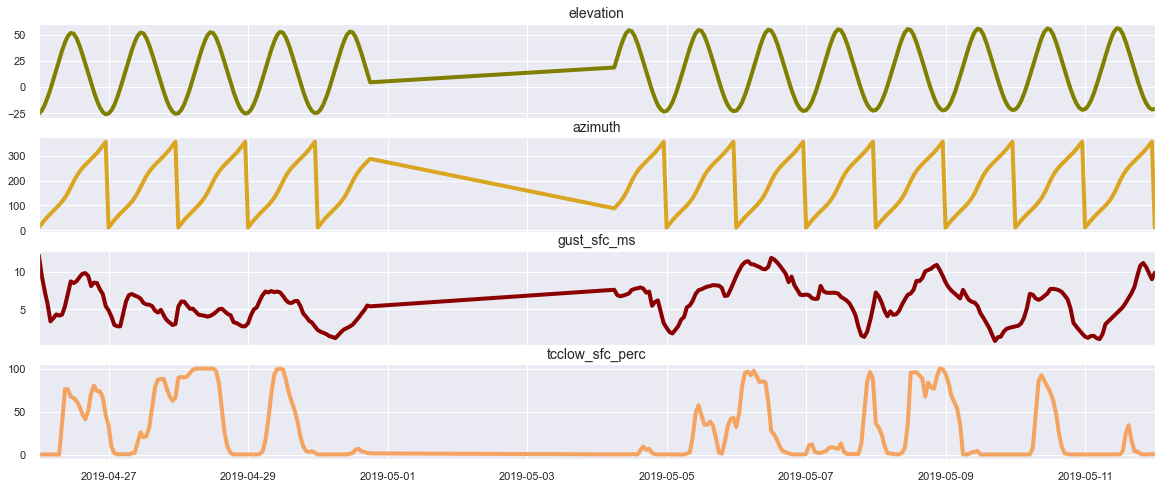

In [37]:
#### DATA SELECTION ####
start_index = pd.to_datetime("2019-04-26 00:00:00")
end_index = pd.to_datetime("2019-05-12 00:00:00")
f_to_plot = ['elevation', 'azimuth','gust_sfc_ms', 'tcclow_sfc_perc']

#reduced timeframe
df_reduced = df[(df.index <= end_index) & (df.index >= start_index)]

#### PLOTTING #####
color=iter(['olive', 'goldenrod', 'darkred', 'sandybrown', 'sienna', 'grey'])
fig, axs = plt.subplots(len(f_to_plot), sharex=True, figsize=(20,len(f_to_plot)*2), facecolor='w')
for f, axes in zip(f_to_plot, axs): 
    c=next(color, 'goldenrod')
    axes.plot(df_reduced[f], color=c, lw=4)
    axes.set_title(f, fontsize=14)
    axes.set_xlim(left=start_index, right=end_index)
plt.show(fig);

## Dealing with inconsistent / artificial Data

Various approaches to this interpolated data timespan have been discussed:
- (chosen approach) cutoff at `2019-04-30 06:00:00` 
- keeping it as it is, since these 4 days will most likely not effect how the prediction models perform
- (future work) interpolation with *Standard Week* as done above for target data 

In [38]:
#cutting of data due to inconsistency
cutoff_timestamp = "2019-04-30 06:00:00"
print('New end date due to artificial GFS Data: ', pd.to_datetime(cutoff_timestamp))

span_before = df.index[-1] - df.index[0]
span_after = pd.to_datetime(cutoff_timestamp) - df.index[0]

print('Number of days BEFORE cutoff due to Artificial GFS Data: ', span_before.days)
print('Number of days AFTER cutoff due to Artificial GFS Data: ', span_after.days)
print()
print('Number of days cut off: ', (span_before-span_after).days)

New end date due to artificial GFS Data:  2019-04-30 06:00:00
Number of days BEFORE cutoff due to Artificial GFS Data:  539
Number of days AFTER cutoff due to Artificial GFS Data:  484

Number of days cut off:  55


In [39]:
df = df[(df.index <= pd.to_datetime(cutoff_timestamp))]
print('First and last observations:')
pd.concat([df.head(1), df.tail(1)])

First and last observations:


,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,lagged_NetConsumption_MW,lagged_energyprice_euro_MWh,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,r_pl925_perc,r_pl950_perc,shtfl_sfc_wm2,t_100m_k,t_2m_k,t_pfg30_k,tcclow_sfc_perc,tccmedium_sfc_perc,wdir_100m_dn,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,azimuth,elevation,Date,year,month,day,hour,minute,weekday,day_hour_minute
2018-01-01 06:00:00,0.486251,0.911849,0.425598,3142.133333,-71.616667,0.0,16.777032,1349.927656,99212.06250,0.559356,0.005105,0.004852,89.975,83.075,-58.444885,280.079346,280.496348,279.811816,99.375,49.5,54.455224,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,111.880959,-12.132894,2018-01-01,2018,1,1,6,0,Monday,0.25
2019-04-30 06:00:00,0.017906,0.017906,0.017906,7827.066667,51.053333,180.5,1.183948,83.199766,102202.15625,0.228296,0.005010,0.004551,76.100,79.625,6.353638,281.250000,281.799976,281.325000,0.000,0.0,181.629068,186.329332,181.860202,193.058927,1.647042,0.883608,1.705760,5.342644,89.258858,17.706749,2019-04-30,2019,4,30,6,0,Tuesday,1.25


# Data Exploration

For a thorough data exploration, `df.working_day` and `df.summer` will be added. 

## Adding column "working_day"

Since the energy consumption in the grid might be correlated to the day being a working or non working day, a feature called working day is implemented. All the weekend days and the national holidays for Germany will be categorized as non-working days.

In [40]:
#workalendar is a non-standard, single-use libary 
#workalendar is hence is loaded seperate
try:
    import workalendar
    print("module 'workalendar' is installed.")
except ModuleNotFoundError:
    print("module 'workalendar' will be installed and imported.")
    print()
    ! pip install workalendar
    import workalendar

module 'workalendar' is installed.


In [41]:
from workalendar.europe import Germany
cal = Germany()
df["working_day"] = df["Date"].apply(lambda x: cal.is_working_day(x))
df.sample(2)

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,lagged_NetConsumption_MW,lagged_energyprice_euro_MWh,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,r_pl925_perc,r_pl950_perc,shtfl_sfc_wm2,t_100m_k,t_2m_k,t_pfg30_k,tcclow_sfc_perc,tccmedium_sfc_perc,wdir_100m_dn,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,azimuth,elevation,Date,year,month,day,hour,minute,weekday,day_hour_minute,working_day
2018-04-24 05:00:00,0.449873,0.596958,0.147085,6023.566667,35.325000,7.50,13.350000,619.46051,101047.540,0.463102,0.005852,0.005757,98.675000,99.275000,-24.401416,280.665869,281.169092,280.6000,95.0,83.25,44.571499,41.290553,44.902418,72.273606,10.944628,6.622840,10.753888,16.792153,78.898369,6.788054,2018-04-24,2018,4,24,5,0,Tuesday,1.208333,True
2019-02-16 12:30:00,0.256847,0.280102,0.023255,4458.033333,35.746667,370.75,9.923737,475.19682,102244.375,-0.303243,0.005006,0.004659,22.670353,35.595353,52.003571,281.762500,283.033506,281.7125,0.0,0.00,60.721277,59.338585,60.910488,82.978777,8.146384,5.556011,8.070332,14.376415,194.835159,24.601940,2019-02-16,2019,2,16,12,30,Saturday,5.520833,False


## Adding column "season"

Since the location of our wind farm is in northern Germany we will apply a filter on our dataset that separates the dates into two basic seasons (summer and winter). As the summer in northern Germany tends to be shorter, only the months from May to August will be declared summer months.

In [42]:
def season_calc(month):
    if month in [5,6,7,8]:
        return 1 #"summer"
    else:
        return 0 #"winter"
    
df['summer'] = df.Date.dt.month.apply(season_calc)
df.head(2)

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,lagged_NetConsumption_MW,lagged_energyprice_euro_MWh,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,r_pl925_perc,r_pl950_perc,shtfl_sfc_wm2,t_100m_k,t_2m_k,t_pfg30_k,tcclow_sfc_perc,tccmedium_sfc_perc,wdir_100m_dn,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,azimuth,elevation,Date,year,month,day,hour,minute,weekday,day_hour_minute,working_day,summer
2018-01-01 06:00:00,0.486251,0.911849,0.425598,3142.133333,-71.616667,0.0,16.777032,1349.927656,99212.062500,0.559356,0.005105,0.004852,89.975000,83.0750,-58.444885,280.079346,280.496348,279.811816,99.375000,49.500000,54.455224,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,111.880959,-12.132894,2018-01-01,2018,1,1,6,0,Monday,0.250000,False,0
2018-01-01 06:10:00,0.528225,0.932739,0.404513,3144.800000,-72.540000,0.0,16.748651,1350.376965,99220.020833,0.554256,0.005088,0.004833,89.854167,82.9375,-58.558706,280.057788,280.470277,279.787207,99.354167,54.458333,55.784078,53.253883,56.181451,60.237190,16.589409,9.804977,16.657162,21.955989,113.717751,-10.743970,2018-01-01,2018,1,1,6,10,Monday,0.256944,False,0


## Standard Day Analysis

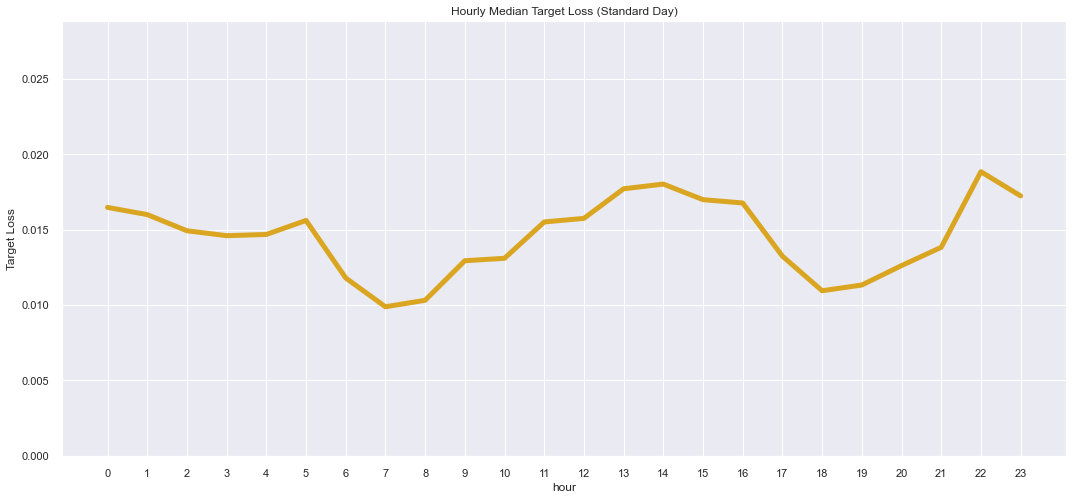

In [43]:
#Plotting median hourly power loss for a standard day
df.groupby('hour')['target_losses_norm'].median().plot(figsize=(18, 8), color=color_1, linewidth=5)
_ = plt.ylabel('Target Loss')
_ = plt.ylim([0, max(df.groupby('hour')['target_losses_norm'].median()) + 0.01])
_ = plt.xticks(df['hour'].unique())
_ = plt.title('Hourly Median Target Loss (Standard Day)')

**Observations:**
- Energy lost through Feed-In Management Events is greater in the afternoon. This is potentially explained by greater solar power production in the afternoon. 
- Great energy loss is observable in the evenings, potentially explained by the availability of wind energy in the evening combined with lower energy consumption in the grid.

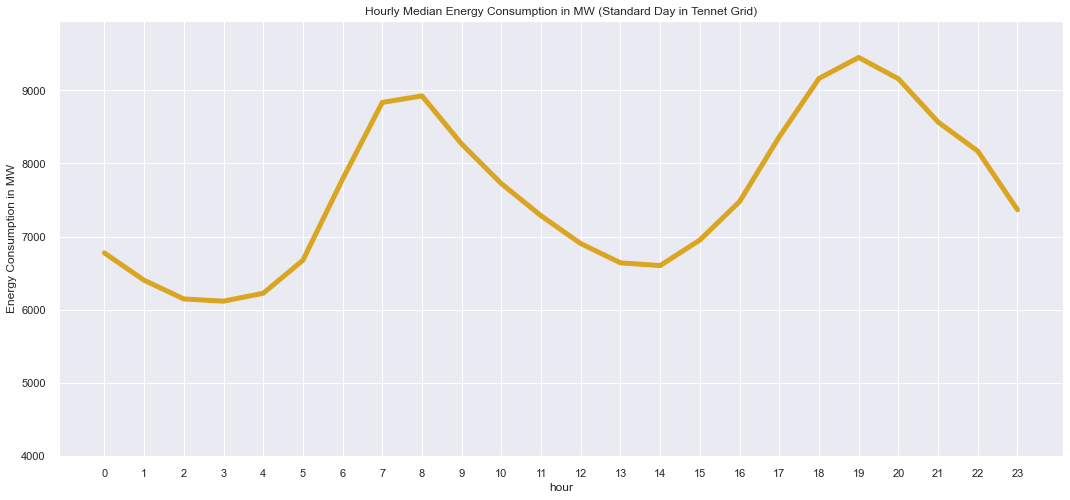

In [44]:
#Plotting median hourly energy consumption for a standard day 
df.groupby('hour')['lagged_NetConsumption_MW'].median().plot(figsize=(18, 8), color=color_1, linewidth=5)
_ = plt.ylabel('Energy Consumption in MW')
_ = plt.ylim([4000, max(df.groupby('hour')['lagged_NetConsumption_MW'].median()) + 500])
_ = plt.xticks(df['hour'].unique())
_ = plt.title('Hourly Median Energy Consumption in MW (Standard Day in Tennet Grid)')

**Observation:**
- As expected the graph for the standard energy consumption behaves in the opposite way to the power loss graph, since consumption peaks, as seen in the morning and evening hours, make it improbable that too much energy (and corresponding losses) is generated.

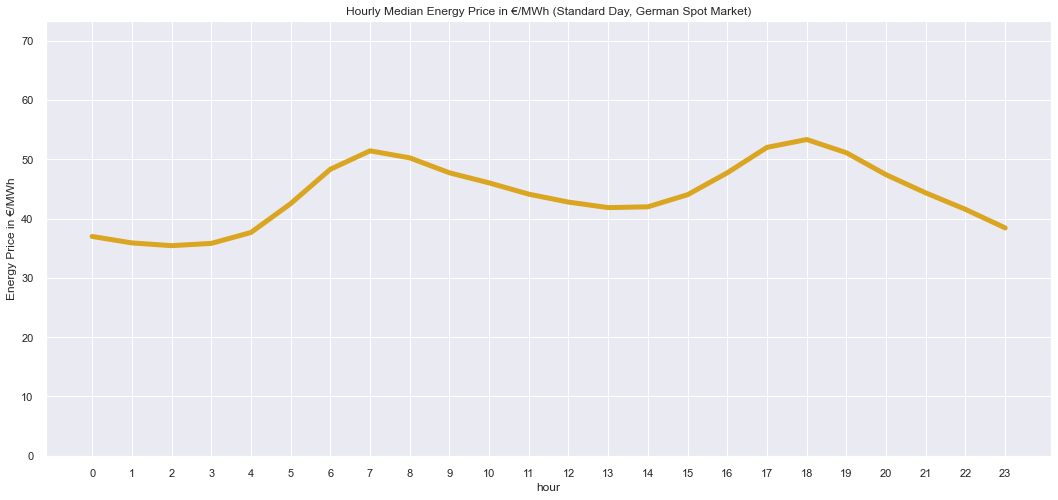

In [45]:
#Plotting median hourly energy price for a standard day 
df.groupby('hour')['lagged_energyprice_euro_MWh'].median().plot(figsize=(18, 8), color=color_1, linewidth=5)
_ = plt.ylabel('Energy Price in €/MWh')
_ = plt.ylim([0, max(df.groupby('hour')['lagged_energyprice_euro_MWh'].median()) + 20])
_ = plt.xticks(df['hour'].unique())
_ = plt.title('Hourly Median Energy Price in €/MWh (Standard Day, German Spot Market)')

**Observation:**
- As expected the graph for the standard energy price behaves in correlation to the consumption as high energy demand causes higher energy prices.

## Standard Week Analysis

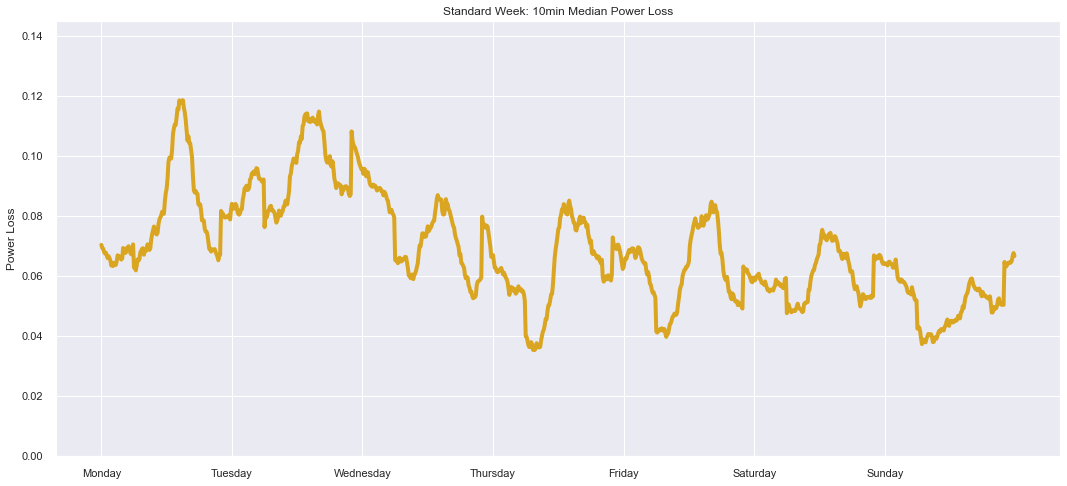

In [46]:
#Plotting median 10-minutely energy consumption for the standard week
df.groupby('day_hour_minute')['target_losses_norm'].mean().plot(figsize=(18, 8), color=color_1, linewidth=4)
_ = plt.ylabel('Power Loss')
_ = plt.xlabel('')
_ = plt.ylim([0, max(df.groupby('day_hour_minute')['target_losses_norm'].median()) + 0.1])
#the xticks are values between 0 and 7 (e.g., just like day_hour_minute), hence the np.arange() command
_ = plt.xticks(np.arange(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
_ = plt.title('Standard Week: 10min Median Power Loss')

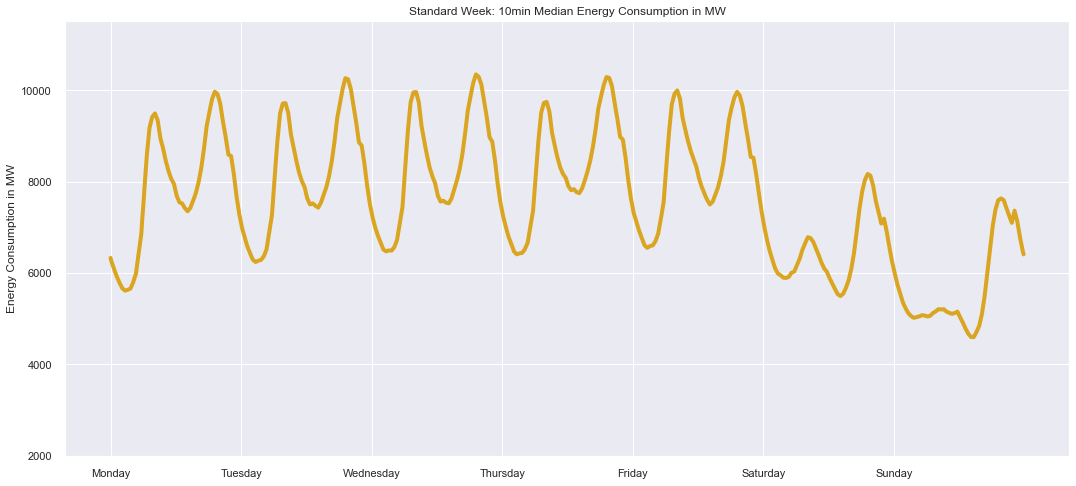

In [47]:
#Plotting median 10-minutely energy consumption for the standard week
df.groupby('day_hour_minute')['lagged_NetConsumption_MW'].mean().plot(figsize=(18, 8), color=color_1, linewidth=4)
_ = plt.ylabel('Energy Consumption in MW')
_ = plt.xlabel('')
_ = plt.ylim([2000, max(df.groupby('day_hour_minute')['lagged_NetConsumption_MW'].median()) + 1000])
#the xticks are values between 0 and 7 (e.g., just like day_hour_minute), hence the np.arange() command
_ = plt.xticks(np.arange(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
_ = plt.title('Standard Week: 10min Median Energy Consumption in MW')

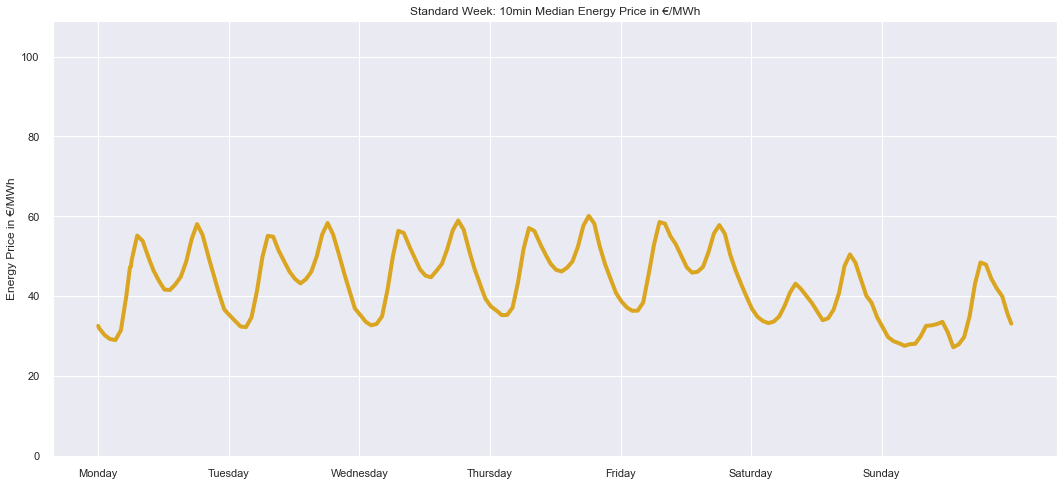

In [48]:
#Plotting median 10-minutely energy consumption for the standard week
df.groupby('day_hour_minute')['lagged_energyprice_euro_MWh'].mean().plot(figsize=(18, 8), color=color_1, linewidth=4)
_ = plt.ylabel('Energy Price in €/MWh')
_ = plt.xlabel('')
_ = plt.ylim([0, max(df.groupby('day_hour_minute')['lagged_energyprice_euro_MWh'].median()) + 50])
#the xticks are values between 0 and 7 (e.g., just like day_hour_minute), hence the np.arange() command
_ = plt.xticks(np.arange(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
_ = plt.title('Standard Week: 10min Median Energy Price in €/MWh')

**Observation:**
- All the graphs seem to trend down on the weekends, since due to different acitvity patterns in industry and personal lives the energy consumption is lower, which causes the energy price and the power loss graph to behave correspondingly.

## Graph: Power available vs Power fed into the grid

As discussed above: A Feed-In Managment event is given, when the available power is greater than the power that is (and can be) fed into the grid. In the following graph the Feed-In Management over the given timespan is shown (resolution: weekly). 

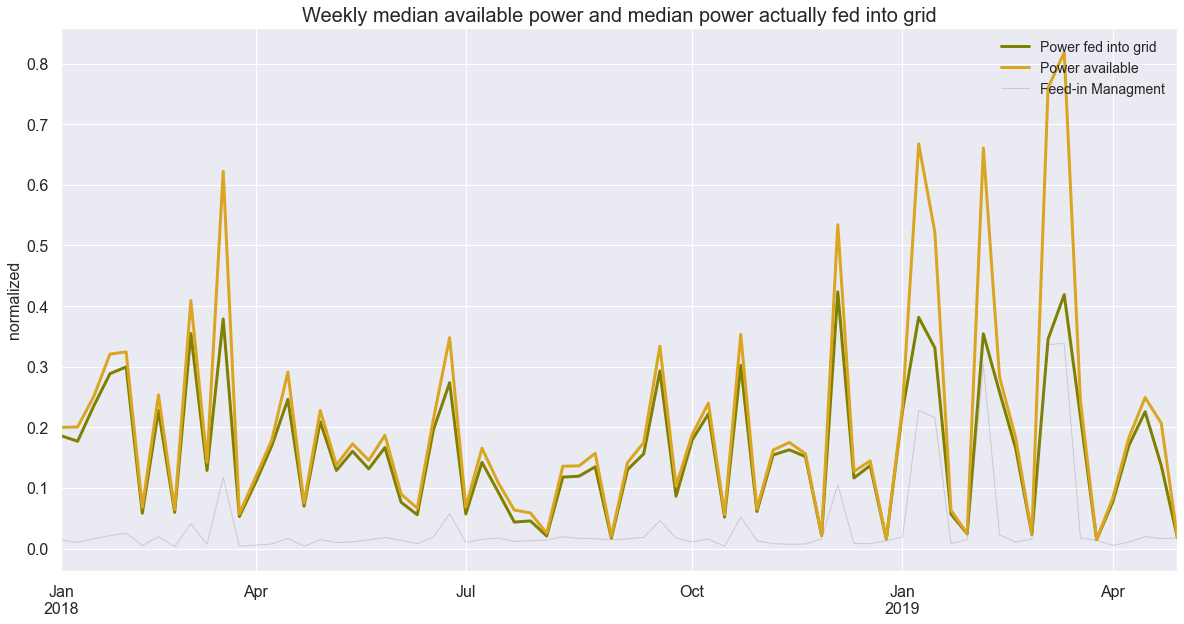

In [49]:
###### DATA SELECTION ###### 
weekly_feedin = df['power_mw_obsnorm'].resample('W').median()
weekly_available = df['power_available_mw_obsnorm'].resample('W').median()
weekly_loss = df['target_losses_norm'].resample('W').median()
###### DATA PLOTTING ###### 
fig, ax = plt.subplots(figsize=(20,10))
weekly_feedin.plot(label='Power fed into grid',color='olive', lw=3)
weekly_available.plot(label='Power available',color='goldenrod', lw=3)
weekly_loss.plot(label='Feed-in Managment',color='grey', alpha=0.3,  lw=1)

###### PLOT SETTINGS #######
plt.ylabel('normalized', fontsize=16)
plt.tick_params(labelsize=16)
plt.title('Weekly median available power and median power actually fed into grid', fontsize=20)
plt.legend(loc='upper right', fontsize=14)

### CLEANING WORKSPACE ###
del weekly_feedin, weekly_available, weekly_loss

plt.show;

**Observation:** At any given week, the available power is greater than the power fed into the grid (used power). Hence, at any given week curtailment of power fed into the system is observable (feed-in managment / EinsMan Events). In an ideal week, the power available nearly equals the power used/fed into the grid - a balanced energy grid with very little energy being lost (read: not created, e.g., due to pitching of wind turbine blades). 

## Graph: [daily] Influence of Wind on the Feed-In Management 

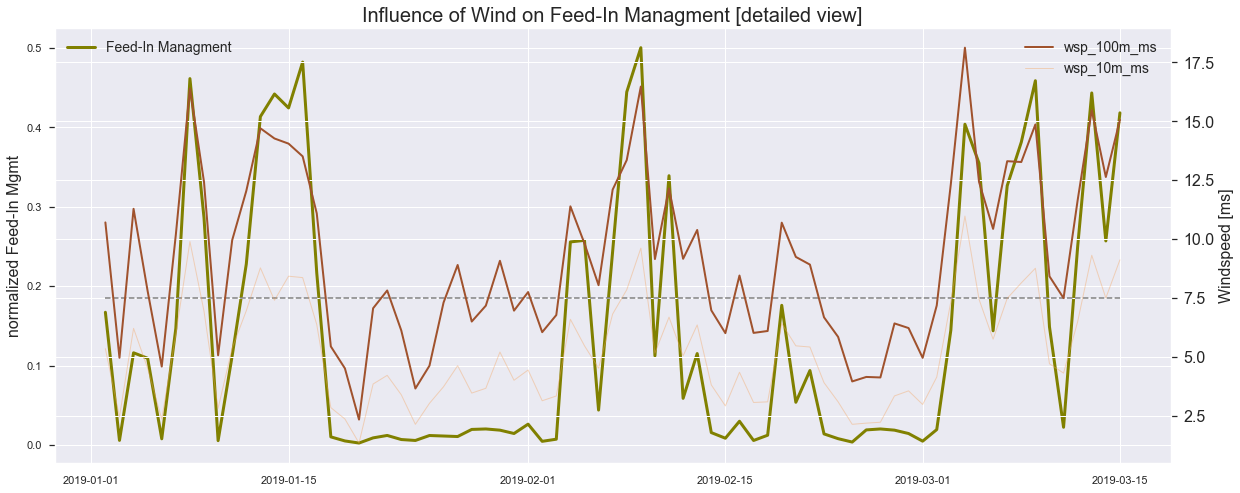

In [50]:
###### DATA SELECTION ###### 
start_index = pd.to_datetime("2019-01-02 00:00:00")
end_index = pd.to_datetime("2019-03-15 00:00:00")
#reduced timeframe
df_reduced = df[(df.index <= end_index) & (df.index >= start_index)]
#resampling
weekly_wsp_100 = df_reduced['wsp_100m_ms'].resample('D').mean()
weekly_wsp_10 = df_reduced['wsp_10m_ms'].resample('D').mean()
weekly_loss = df_reduced['target_losses_norm'].resample('D').mean()

###### DATA PLOTTING ###### 
fig, ax1 = plt.subplots(figsize=(20,8))
#left axis
ax1.set_ylabel('normalized Feed-In Mgmt', fontsize=16)
ax1.plot(weekly_loss, label='Feed-In Managment',color='olive',  lw=3)
ax1.legend(loc='upper left', fontsize=14)
#right axis
ax2 = ax1.twinx()
ax2.plot(weekly_wsp_100, label='wsp_100m_ms',color='sienna', lw=2)
ax2.plot(weekly_wsp_10, label='wsp_10m_ms',color='sandybrown', lw=1, alpha=0.4)
ax2.legend(loc='upper right', fontsize=14)
ax2.set_ylabel('Windspeed [ms]', fontsize=16)
ax2.legend(loc='upper right', fontsize=14)
#general settings
plt.tick_params(labelsize=16)
plt.title('Influence of Wind on Feed-In Managment [detailed view]', fontsize=20)
plt.hlines(7.5, start_index, end_index, linestyles='dashed', colors = 'grey')

### CLEANING WORKSPACE ###
del weekly_wsp_100, weekly_wsp_10, weekly_loss

plt.show;

**Observations:** 
- As a rule-of-thumb, for `wsp_100m_m`, windspeeds above a certain value (e.g., 7.5 ms) seem to correspond with Feed-In Management Events

## Graph: Correlation Windspeed and  Feed-In Management

<Figure size 1440x864 with 0 Axes>

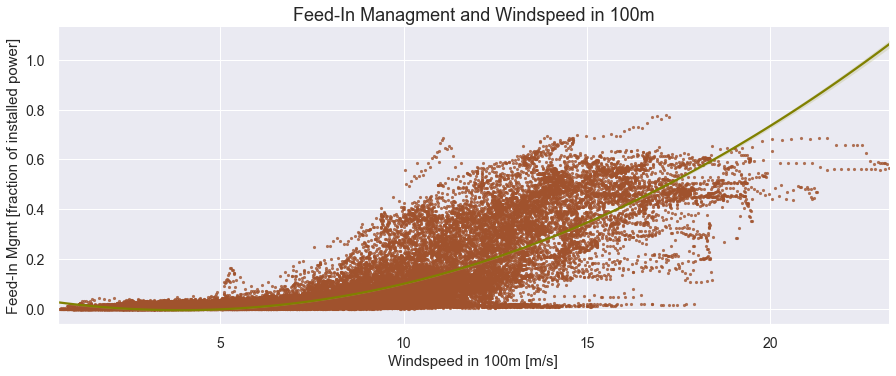

In [51]:
###### DATA SELECTION ###### 
x_selected = "wsp_100m_ms"
y_selected = "target_losses_norm"

###### DATA PLOTTING ###### 
plt.figure(figsize=(20,12))
g = sns.lmplot(data = df,
            x=x_selected,
            y=y_selected, 
            height=5, 
            aspect=2.5,
            order=2, 
            line_kws={'color': 'olive'}, 
            scatter_kws={'color': 'sienna', 's':10 })
#general plot settings
plt.title('Feed-In Managment and Windspeed in 100m', fontsize=18)
plt.xlabel('Windspeed in 100m [m/s]', fontsize=15)
plt.ylabel('Feed-In Mgmt [fraction of installed power]', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


### CLEANING WORKSPACE ###
del x_selected, y_selected

plt.show(g);


**Observations:** 
- The correlation between windspeeds and power loss seems to be somewhat quadratic.

## Graph: dswrf_sfc_wm2 | elevation | azimuth

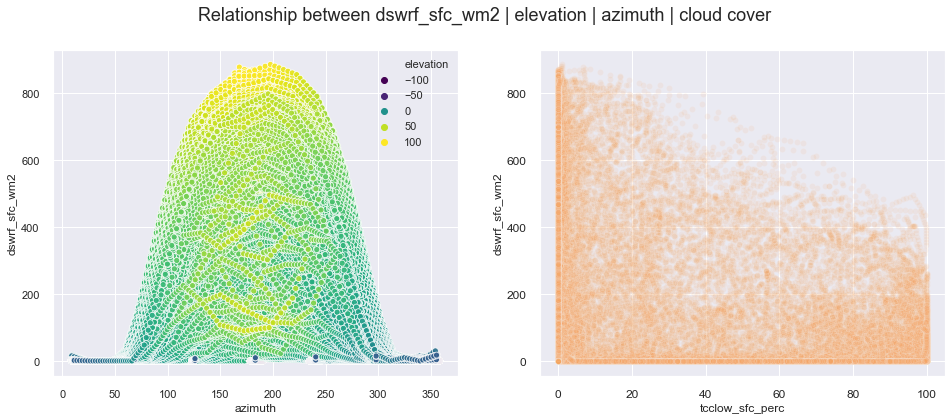

In [52]:
###### DATA SELECTION 1 ###### 
x_selected = df.azimuth
y_selected = df.dswrf_sfc_wm2
hue_selected = df.elevation

###### DATA PLOTTING ###### 
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,6))
fig.suptitle('Relationship between dswrf_sfc_wm2 | elevation | azimuth | cloud cover', fontsize=18)
###### PLOT 1 ###### 
sns.scatterplot(ax=ax1, 
                x=x_selected,
                y=y_selected,
                hue= hue_selected, 
                palette='viridis',
                alpha=0.925, 
                color='darkred')

###### DATA SELECTION 2 ###### 
x_selected = df.tcclow_sfc_perc
y_selected = df.dswrf_sfc_wm2
###### PLOT 2 ###### 
sns.scatterplot(ax=ax2, 
                x=x_selected,
                y=y_selected,
                palette='viridis',
                alpha=0.1,
                color='sandybrown')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

### CLEANING WORKSPACE ###
del x_selected, y_selected

plt.show();

**Observation:** 
- The potential for high solar radiation is given when the sun shines from south (e.g., azimuth between 150° and 210°) and has a high elevation angle (e.g., > 25°). Cloud cover leads to less solar radiation even at great sun elevations. 
- Greater cloud cover leads to less intense solar radiation (displayed for low clouds). 

## Graph: four different wind features

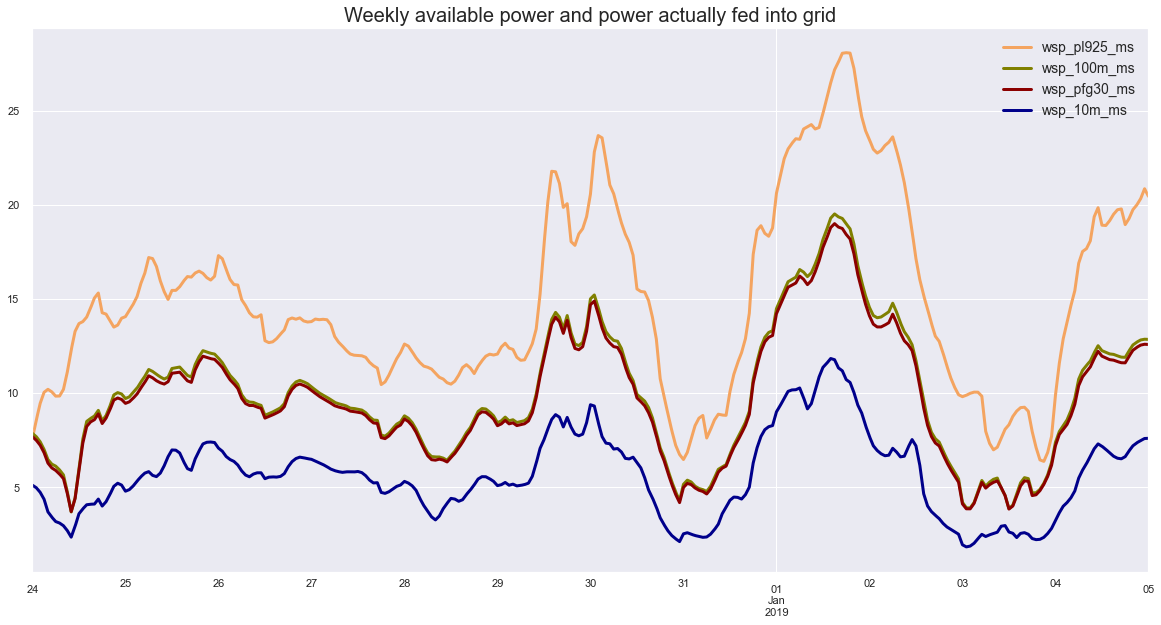

In [53]:
###### DATA SELECTION ###### 
start_index = pd.to_datetime("2018-12-24 00:00:00")
end_index = pd.to_datetime("2019-01-5 00:00:00")
#reduced timeframe
df_reduced = df[(df.index <= end_index) & (df.index >= start_index)]


###### DATA SELECTION ###### 
wsp_100m_ms = df_reduced['wsp_100m_ms']
wsp_10m_ms = df_reduced['wsp_10m_ms']
wsp_pfg30_ms = df_reduced['wsp_pfg30_ms']
wsp_pl925_ms = df_reduced['wsp_pl925_ms']


###### DATA PLOTTING ###### 
fig, ax = plt.subplots(figsize=(20,10))
wsp_pl925_ms.plot(label='wsp_pl925_ms',color='sandybrown', lw=3)
wsp_100m_ms.plot(label='wsp_100m_ms',color='olive', lw=3)
wsp_pfg30_ms.plot(label='wsp_pfg30_ms',color='darkred', lw=3)
wsp_10m_ms.plot(label='wsp_10m_ms',color='darkblue', lw=3)

###### PLOT SETTINGS #######
plt.title('Weekly available power and power actually fed into grid', fontsize=20)
plt.legend(loc='upper right', fontsize=14)

### CLEANING WORKSPACE ###
del wsp_100m_ms, wsp_10m_ms, wsp_pfg30_ms, wsp_pl925_ms

plt.show();

**Observation:** 
- The different features expressing windspeed are highly correlated, especially noteable for `wsp_100m_ms` and `wsp_pfg30_ms`. Dropping of some of these features needs to be discussed. 

## Implementing circular variables for month of the year, day of the week and 10-minute interval of the day (better compatibility with models)

To avoid the use of dummy variables for the month of the year, the day of the week and the 10-minute interval of the day variables these values will be transformed into circular coordinates. This will make the data more compatible with  models like LSTM Recurrent Neural Networks and still keep the corresponding time integrity, since the transformed coordinates for for example 23:50h will still be very close to the transformed variables of 00:10h.

In [54]:
df['index1'] = df.index
df['monthnumber'] = df.index1.dt.month -1
df['weekdaynumber'] = df.index1.dt.weekday
df['ten_min_interval_float']=df.hour+df.minute/60.0

df['month_transformed_x']=np.sin(2.*np.pi*df.monthnumber/12)
df['month_transformed_y']=np.cos(2.*np.pi*df.monthnumber/12)
df['weekday_transformed_x']=np.sin(2.*np.pi*df.weekdaynumber/7)
df['weekday_transformed_y']=np.cos(2.*np.pi*df.weekdaynumber/7)
df['ten_min_interval_transformed_x']=np.sin(2.*np.pi*df.ten_min_interval_float/(24))
df['ten_min_interval_transformed_y']=np.cos(2.*np.pi*df.ten_min_interval_float/(24))

The plot below shows the kept time integrity in the circular representation of all the different 10-minute intervals of a day. The different colours show the different hours.

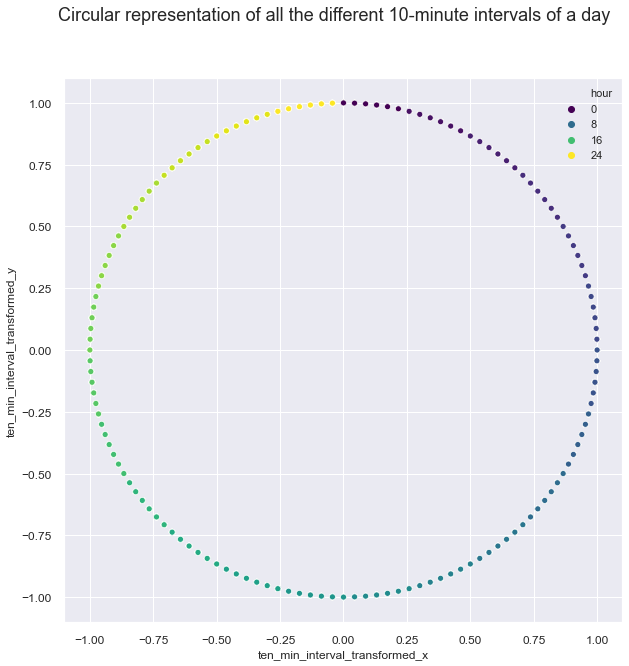

In [55]:
###### DATA SELECTION 1 ###### 
x_selected = df.ten_min_interval_transformed_x
y_selected = df.ten_min_interval_transformed_y
hue_selected = df.hour

###### DATA PLOTTING ###### 
fig, (ax1) = plt.subplots(ncols=1, figsize=(10,10))
fig.suptitle('Circular representation of all the different 10-minute intervals of a day', fontsize=18)
###### PLOT 1 ###### 
sns.scatterplot(ax=ax1, 
                x=x_selected,
                y=y_selected,
                hue= hue_selected, 
                palette='viridis',
                alpha=0.925, 
                color='darkred')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

### CLEANING WORKSPACE ###
del x_selected, y_selected

plt.show();

## Wind Rose (Wind Vector)

In the data, `wdir_100m_dn` and `wdir_10m_dn`, give the wind direction in units of degrees. Angles do not make good model inputs, 360° and 0° should be close to each other, and wrap around smoothly. Therefore, a similar transformation as for the time data is used.

Right now the distribution of wind data looks like this:

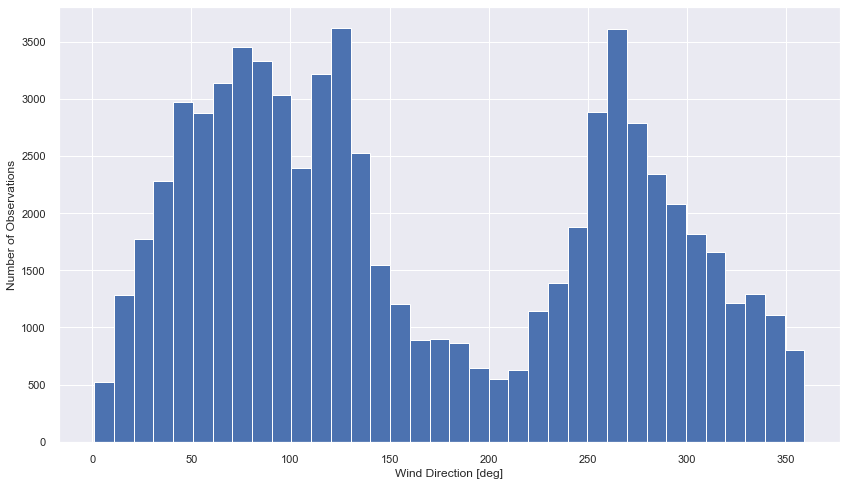

In [56]:
plt.hist(df['wdir_100m_dn'], bins=36);
plt.xlabel('Wind Direction [deg]');
plt.ylabel('Number of Observations');

This data will be easier for the model to interpret if the wind direction and velocity columns are converted.

In [57]:
# Convert to radians
wdir_100m_rad = df['wdir_100m_dn']*np.pi / 180
wdir_10m_rad = df['wdir_10m_dn']*np.pi / 180

# Calculate the wind x and y components.
df['transformed_wdir_100m_dn_x'] = np.cos(wdir_100m_rad)
df['transformed_wdir_100m_dn_y'] = np.sin(wdir_100m_rad)
df['transformed_wdir_10m_dn_x'] = np.cos(wdir_10m_rad)
df['transformed_wdir_10m_dn_y'] = np.sin(wdir_10m_rad)

Now the distribution of wind vectors is is better to be interpreted

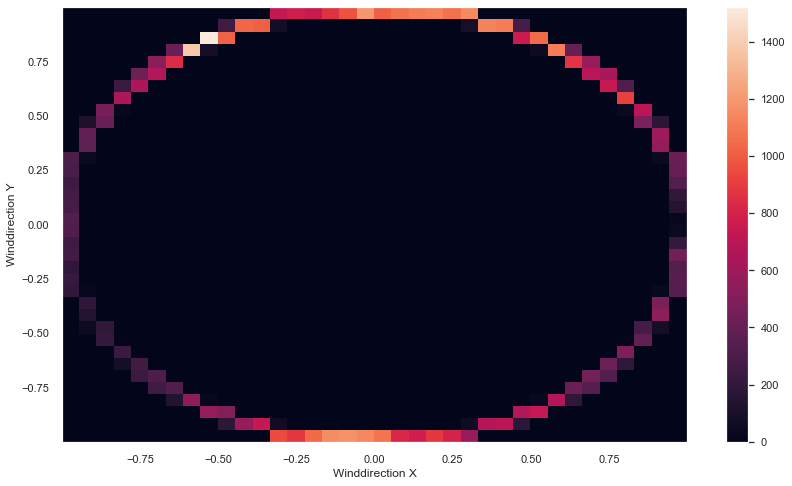

In [58]:
plt.hist2d(df['transformed_wdir_100m_dn_x'], df['transformed_wdir_100m_dn_y'], bins=(36, 36))
plt.colorbar()
plt.xlabel('Winddirection X')
plt.ylabel('Winddirection Y')
ax = plt.gca()
ax.axis('tight');

## Correlation of features with target_losses_norm

To get a feel for the importance of different features the features with the largest absolute correlation coefficients and the correlations inbetween them will be examined with a heatmap.

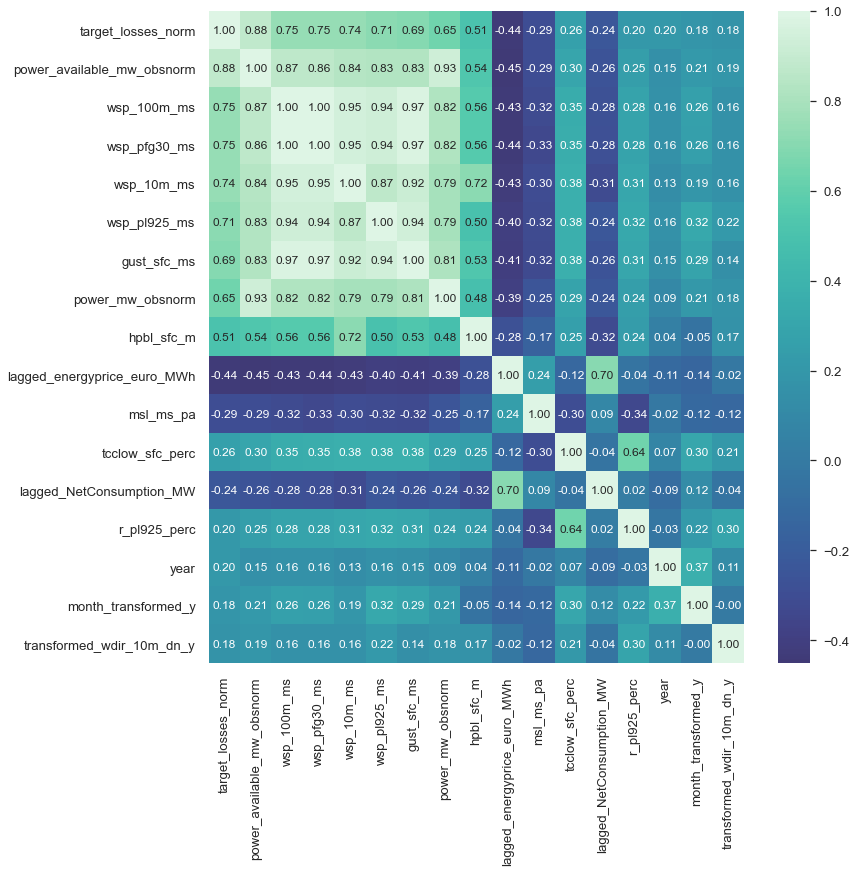

In [59]:
k = 17 #number of variables for heatmap
cols_corr_mat = np.abs(df.corr()).nlargest(k, 'target_losses_norm')['target_losses_norm'].index
cm = np.corrcoef(df[cols_corr_mat].dropna().values.T)
sns.set(font_scale=1.2)
plt.subplots(figsize=(12,12))
hm = sns.heatmap(cm, annot=True, fmt='.2f', annot_kws={'size': 12},
                 yticklabels=cols_corr_mat.values, xticklabels=cols_corr_mat.values, cmap='mako', center=0.0)
plt.show()

**Important:** 
- Since correlation is not the same as causality, the same should be done for the correlation of the feature variables with the first difference of the target data to see, if the features show correlation with the change of the target.

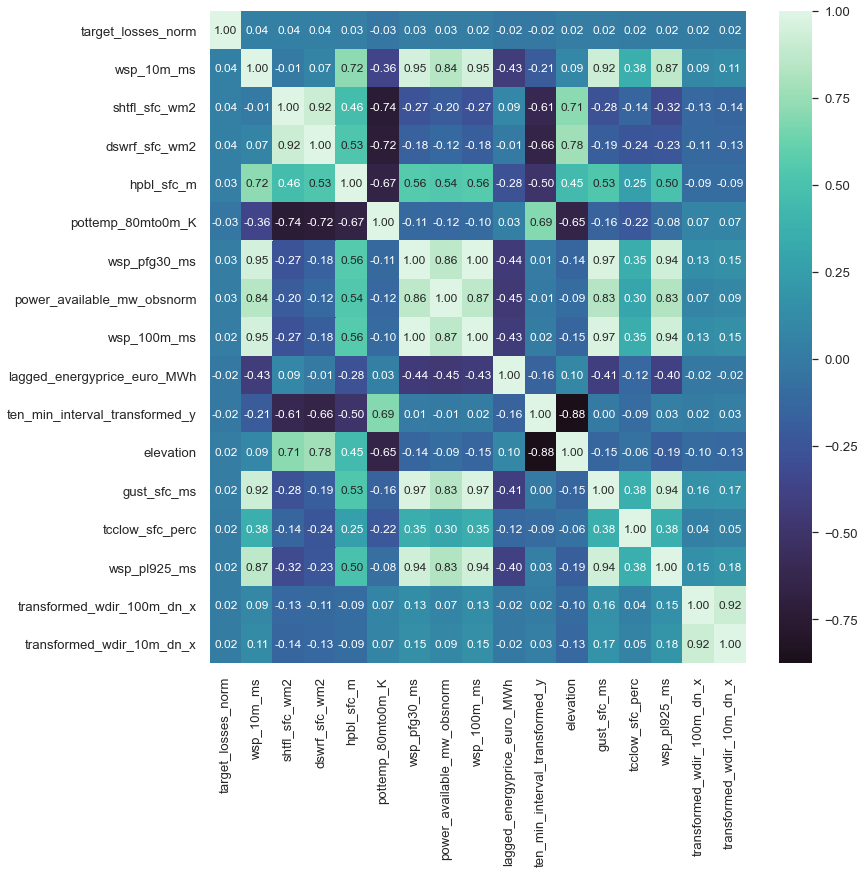

In [60]:
df_corr = df.copy(deep = True)
df_corr['target_losses_norm'] = df_corr['target_losses_norm'].diff(1)
k = 17 #number of variables for heatmap
cols_corr_mat = np.abs(df_corr.corr()).nlargest(k, 'target_losses_norm')['target_losses_norm'].index
cm = np.corrcoef(df_corr[cols_corr_mat].dropna().values.T)
sns.set(font_scale=1.2)
plt.subplots(figsize=(12,12))
hm = sns.heatmap(cm, annot=True, fmt='.2f', annot_kws={'size': 12},
                 yticklabels=cols_corr_mat.values, xticklabels=cols_corr_mat.values, cmap='mako', center=0.0)
plt.show()

**Observation:** 
- The features still carry information, but it can be seen that it is not as valuable as on first thought.

In order to check the correlation of our target variable with past observations of itself an autocorrelation and a partial autocorrelation plot for the last 15 lags will be plotted below.

In [61]:
def acf_pacf_plots(ts, lags, figsize = (12,8)):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = figsize)
    # Plot the ACF of ts for the first "lags" number of lags
    _ = plot_acf(ts, lags = lags, zero = False, ax = ax1, alpha = 0.05)
    # Plot the PACF of ts for the first "lags" number of lags
    _ = plot_pacf(ts, lags = lags, zero = False, ax = ax2, alpha = 0.05)

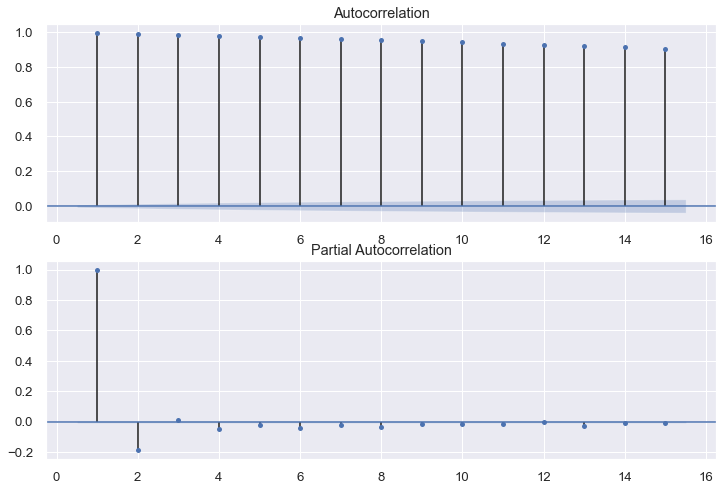

In [62]:
# Create the acf and pacf plots for one week worth of lags
acf_pacf_plots(df['target_losses_norm'], lags = 15, figsize = (12,8))

**Observation:** 
- The past 2 values of our target seem to carry a lot of information for the prediction of the next value.

# Export of Data

The Exploratory Data Analysis ends at this point. The DataFrame (df) is organized and cleaned. For purity and performance reasons, the Machine Learning part of this project will be continued in another Jupyter Notebook. The interface between the Jupyter Notebooks will be given using a `.pkl`file.
- `df_small.pkl` --> DataFrame with only the most important features ready for computational demanding ML models

After thoroughly discussing the different features and examining their correlations with the target and inbetween themselves, we will drop some of them to speed up future models.

In [63]:
df_small = df.copy()

In [64]:
print('Number of columns BEFORE dropping:', len(df_small.columns))
print()
drop_lst = []
drop_lst.append("power_mw_obsnorm")             # information is implied in target_losses_norm and would mean data leakage, if kept together with available power
drop_lst.append("year")                         # no valuable information (not enough years)
drop_lst.append("pottemp_80mto0m_K")            # temperature difference will be included in keeping values on 2m and 100m
drop_lst.append("wdir_pl925_dn")                # will keep direction in 10m and 100m height
drop_lst.append("wdir_pl925_dn")                # will keep direction in 10m and 100m height
drop_lst.append("wdir_pfg30_dn")                # will keep direction in 10m and 100m height
drop_lst.append("t_pfg30_k")                    # will keep temperatures in 2m and 100m height
drop_lst.append("q_2m_1")                       # will keep relative humidity
drop_lst.append("q_pfg30_1")                    # will keep relative humidity
drop_lst.append("wsp_pl925_ms")                 # will keep wind speed in 10m and 100m height
drop_lst.append("wsp_pfg30_ms")                 # will keep wind speed in 10m and 100m height
drop_lst.append("Date")                         # information will be stored circular time coordinates
drop_lst.append("day")                          # information will be stored circular time coordinates
drop_lst.append("hour")                         # information will be stored circular time coordinates
drop_lst.append("weekday")                      # information will be stored circular time coordinates
drop_lst.append("month")                        # information will be stored circular time coordinates
drop_lst.append("minute")                       # information will be stored circular time coordinates
drop_lst.append("monthnumber")                  # information will be stored circular time coordinates
drop_lst.append("weekdaynumber")                # information will be stored circular time coordinates
drop_lst.append("ten_min_interval_float")       # information will be stored circular time coordinates
drop_lst.append("index1")                       # was only a helper variable
drop_lst.append("r_pl950_perc")
drop_lst.append("tccmedium_sfc_perc")
drop_lst.append('azimuth')
drop_lst.append('elevation')
drop_lst.append('summer')
drop_lst.append('wdir_10m_dn')
drop_lst.append('wdir_100m_dn')
drop_lst.append('day_hour_minute')


# dropping the columns
df_small.drop(columns = drop_lst, inplace = True)

print('Number of remaining Columns AFTER dropping:', len(df_small.columns))
print(list(df_small.columns))
df_small.head(2)

Number of columns BEFORE dropping: 54

Number of remaining Columns AFTER dropping: 26
['power_available_mw_obsnorm', 'target_losses_norm', 'lagged_NetConsumption_MW', 'lagged_energyprice_euro_MWh', 'dswrf_sfc_wm2', 'gust_sfc_ms', 'hpbl_sfc_m', 'msl_ms_pa', 'r_pl925_perc', 'shtfl_sfc_wm2', 't_100m_k', 't_2m_k', 'tcclow_sfc_perc', 'wsp_100m_ms', 'wsp_10m_ms', 'working_day', 'month_transformed_x', 'month_transformed_y', 'weekday_transformed_x', 'weekday_transformed_y', 'ten_min_interval_transformed_x', 'ten_min_interval_transformed_y', 'transformed_wdir_100m_dn_x', 'transformed_wdir_100m_dn_y', 'transformed_wdir_10m_dn_x', 'transformed_wdir_10m_dn_y']


,power_available_mw_obsnorm,target_losses_norm,lagged_NetConsumption_MW,lagged_energyprice_euro_MWh,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,r_pl925_perc,shtfl_sfc_wm2,t_100m_k,t_2m_k,tcclow_sfc_perc,wsp_100m_ms,wsp_10m_ms,working_day,month_transformed_x,month_transformed_y,weekday_transformed_x,weekday_transformed_y,ten_min_interval_transformed_x,ten_min_interval_transformed_y,transformed_wdir_100m_dn_x,transformed_wdir_100m_dn_y,transformed_wdir_10m_dn_x,transformed_wdir_10m_dn_y
2018-01-01 06:00:00,0.911849,0.425598,3142.133333,-71.616667,0.0,16.777032,1349.927656,99212.062500,89.975000,-58.444885,280.079346,280.496348,99.375000,16.548291,9.772748,False,0.0,1.0,0.0,1.0,1.000000,6.123234e-17,0.581339,0.813661,0.61653,0.787331
2018-01-01 06:10:00,0.932739,0.404513,3144.800000,-72.540000,0.0,16.748651,1350.376965,99220.020833,89.854167,-58.558706,280.057788,280.470277,99.354167,16.589409,9.804977,False,0.0,1.0,0.0,1.0,0.999048,-4.361939e-02,0.562313,0.826924,0.59827,0.801294


In [65]:
path = './data/df_small.pkl'
df_small.to_pickle(path)
Path(path).is_file()

print('This cell was last run on: ')
print(datetime.now())

This cell was last run on: 
2020-11-20 21:03:20.874885
